In [1]:
from math import inf
from math import log
import numpy as np
from scipy.stats import nbinom
from collections import defaultdict
from scipy.optimize import minimize
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# log func

In [2]:
def log_func(number):
    if number > 0:
        return log(number)
    else:
        return -inf

# log-sum-exp

In [3]:
# HMM Notes p17
# log sum(exp(x1)+exp(x2)+...)
# x: list
# result: scalar
def logSumExp(x):
    m = max(x)
    if m == -inf: # infinity
        return -inf
    else:
        minus_m = np.array(x) - m
        result = m + log(sum(np.exp(minus_m)))
        return result   

In [ ]:
# examples
# x = list(range(-100,-50))
# log(sum(np.exp(x)))
# logSumExp(x)

# log likelihood f(x)

In [4]:
# Notes p2
# x: scalar. Realization from NB distribution
# alpha, beta: scalar. Parameters from Gamma distribution
# E: list. Normalization factor for n-th sequence
# result: scalar. Log likelihood f(x)
def lnNB(x, alpha, beta, E):
    r = alpha
    p = beta / (E+beta)

    result = nbinom.logpmf(x, r, p) # x follows NB(alpha, beta/(E+beta))
    return result

In [ ]:
# examples
# x = 50
# alpha = 1
# beta = 0.1
# E = 10
# lnNB(x, alpha, beta, E)

# Forward

In [ ]:
# RNA_data: a list of elements 
# observed_data: height
# trans: dictionary, key: string (start codon); value: rho
# alpha_list: a list with length 10 (index 0 to 9)
# beta_list: a list with length 10 (index 0 to 9)
# E: normalizaton factor for each RNA sequence
# stop_codon_list: list of stop codons

In [5]:
def start_codon_false(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E):
    
    # state 1 and 10 to state 1
    log_1_1 = prob_current[0] + log_func(1)
    log_10_1 = prob_current[9] + log_func(1)
    temp = [log_1_1, log_10_1]
    prob_next[0] = logSumExp(temp) + lnNB(observed_data[i+1], alpha_list[0], beta_list[0], E)
    
    return prob_next

In [6]:
def start_codon_true(i, prob_current, prob_next, trans, next_codon, observed_data, alpha_list, beta_list, E):
    
    # state 1 and 10 to state 1
    log_1_1 = prob_current[0] + log_func(1 - trans[next_codon])
    log_10_1 = prob_current[9] + log_func(1)
    temp = [log_1_1, log_10_1]
    prob_next[0] = logSumExp(temp) + lnNB(observed_data[i+1], alpha_list[0], beta_list[0], E)
    
    # state 1 to state 2
    log_1_2 = log_func(trans[next_codon])
    temp = prob_current[0] + log_1_2 + lnNB(observed_data[i+1], alpha_list[1], beta_list[1], E)
    prob_next[1] = temp
    
    return prob_next

In [7]:
def stop_codon_false(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E):
    
    # state 4 and state 7 to state 5
    log_4_5 = prob_current[3] + log(1) 
    log_7_5 = prob_current[6] + log(1)
    temp = [log_4_5, log_7_5]
    prob_next[4] = logSumExp(temp) + lnNB(observed_data[i+1], alpha_list[4], beta_list[4], E)
    
    return prob_next

In [8]:
def stop_codon_true(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E):
    
    # state 4 to state 5
    prob_next[4] = prob_current[3] + log(1) + lnNB(observed_data[i+1], alpha_list[4], beta_list[4], E)
        
    # state 7 to state 8
    prob_next[7] = prob_current[6] + log(1) + lnNB(observed_data[i+1], alpha_list[7], beta_list[7], E)
    
    return prob_next

In [9]:
def forward_algorithm(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list, num_sequence):

    # Find E and observed_data according the order of sequences
    
    E = E[num_sequence - 1]
    observed_data = observed_data[num_sequence - 1]
    RNA_data = RNA_data[num_sequence - 1]
    
    
    sequence_length = len(RNA_data) # length of data
    output = np.zeros((sequence_length, 10))
    prob_current = np.ones(10) * (-inf) # initialize probability, 10 different states
    prob_current[0] = lnNB(observed_data[0], alpha_list[0], beta_list[0], E)
    output[0] = prob_current
    
    for i in range(sequence_length - 1):
        start_codon = False
        stop_codon = False
        next_codon = ""
        prob_next = np.ones(10) * (-inf)
        
        # Check start and stop codon
        if i + 3 < sequence_length:
            next_codon = RNA_data[i+1] + RNA_data[i+2] + RNA_data[i+3]  
        if next_codon in trans.keys():
            start_codon = True
        if next_codon in stop_codon_list:
            stop_codon = True
        
        # start codon is false
        if start_codon == False:       
            
            prob_next = start_codon_false(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E)
        
        # start codon is ture
        elif start_codon == True:   
            prob_next = start_codon_true(i, prob_current, prob_next, trans, next_codon, observed_data, 
                                           alpha_list, beta_list, E)
        
        # stop codon is ture
        if stop_codon == True: 

            prob_next = stop_codon_true(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E)
 
        # stop codon is false
        elif stop_codon == False:

            prob_next = stop_codon_false(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E)
        
       
        # transter to next state with probability 1
        sure_to_transit = [1, 2, 4, 5, 7, 8]
        for k in sure_to_transit:
            temp = prob_current[k] + log(1) + lnNB(observed_data[i+1], alpha_list[k+1], beta_list[k+1], E)
            prob_next[k+1] = temp


        prob_current = prob_next
        output[i+1] = prob_current
  
    return output

In [10]:
def forward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list):
    output = []
    for n in range(1, len(observed_data)+1):
        output.append(forward_algorithm(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list, n))
    return output

# Backward

In [ ]:
# RNA_data: a list of elements 
# observed_data: height
# trans: dictionary, key: string (start codon); value: rho
# alpha_list: a list with length 10 (index 0 to 9)
# beta_list: a list with length 10 (index 0 to 9)
# E: normalizaton factor for each RNA sequence
# stop_codon_list: list of stop codons

In [11]:
def start_codon_false_back(i, prob_current_back, prob_previous_back, observed_data, alpha_list, beta_list, E):
    
    # state 1 to state 1
    temp = prob_current_back[0] + log(1) + lnNB(observed_data[i+1], alpha_list[0], beta_list[0], E) 
    prob_previous_back[0] = temp
 
    return prob_previous_back

In [12]:
def start_codon_true_back(i, prob_current_back, prob_previous_back, trans, next_codon, observed_data, alpha_list, beta_list, E):

    # state 1 to state 1, 2
    temp = log_func(1 - trans[next_codon])
    log_1_1 = prob_current_back[0] + temp + lnNB(observed_data[i+1], alpha_list[0], beta_list[0], E) 
    
    temp = log_func(trans[next_codon])
    log_1_2 = prob_current_back[1] + temp + lnNB(observed_data[i+1], alpha_list[1], beta_list[1], E) 
    
    temp = [log_1_1, log_1_2]
    prob_previous_back[0] = logSumExp(temp)
    
    return prob_previous_back

In [13]:
def stop_codon_false_back(i, prob_current_back, prob_previous_back, observed_data, alpha_list, beta_list, E):
    
    # state 7 to state 5
    prob_previous_back[6] = prob_current_back[4] + log(1) + lnNB(observed_data[i+1], alpha_list[4], beta_list[4], E)
      
    return prob_previous_back

In [14]:
def stop_codon_true_back(i, prob_current_back, prob_previous_back, observed_data, alpha_list, beta_list, E):
    
    # state 7 to state 8
    prob_previous_back[6] = prob_current_back[7] + log(1) + lnNB(observed_data[i+1], alpha_list[7], beta_list[7], E)
    
    return prob_previous_back

In [15]:
def backward_algorithm(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list, num_sequence):
 
    # Find E and observed_data according the order of sequences
    E = E[num_sequence - 1]
    observed_data = observed_data[num_sequence - 1]
    RNA_data = RNA_data[num_sequence - 1]
    
    sequence_length = len(RNA_data) # length of data
    prob_current_back = list(np.zeros(10)) # initialize probability, 10 different states
    output = np.zeros((sequence_length, 10))
    output[sequence_length - 1] = prob_current_back  
    
    iteration_list = np.arange(0, sequence_length-1, 1).tolist()
    iteration_list.reverse()
    for i in iteration_list:
        start_codon = False
        stop_codon = False
        prob_previous_back = list(np.ones(10) * (-inf))
        next_codon = ""
        
        # Check start and stop codon
        if i + 3 < sequence_length:
            next_codon = RNA_data[i+1] + RNA_data[i+2] + RNA_data[i+3]  
            if next_codon in trans.keys():
                start_codon = True
            if next_codon in stop_codon_list:
                stop_codon = True
        
        # start codon is false
        if start_codon == False:       
            prob_previous_back = start_codon_false_back(i, prob_current_back, prob_previous_back, observed_data, 
                                                        alpha_list, beta_list, E)
        
        # start codon is true
        elif start_codon == True:   
            prob_previous_back = start_codon_true_back(i, prob_current_back, prob_previous_back, trans, 
                                                       next_codon, observed_data, alpha_list, beta_list, E)
        
        # stop codon is true
        if stop_codon == True: 
            prob_previous_back = stop_codon_true_back(i, prob_current_back, prob_previous_back, observed_data, 
                                                      alpha_list, beta_list, E) 
        
        # stop codon is false
        elif stop_codon == False:
            prob_previous_back = stop_codon_false_back(i, prob_current_back, prob_previous_back, observed_data, 
                                                       alpha_list, beta_list, E)
     
        
        # traster with probability 1 
        sure_to_transit = [2, 3, 4, 5, 6, 8, 9]
        for k in sure_to_transit:
            temp = prob_current_back[k] + log(1) + lnNB(observed_data[i+1], alpha_list[k], beta_list[k], E)
            prob_previous_back[k-1] = temp


        # state 10 to state 1     
        prob_previous_back[9] = prob_current_back[0] + log(1) + lnNB(observed_data[i+1], alpha_list[0], beta_list[0], E)

        prob_current_back = prob_previous_back 
        output[i] = prob_current_back
        
    return output

In [16]:
def backward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list):
    output = []
    for n in range(1, len(observed_data)+1):
        output.append(backward_algorithm(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list, n))
    return output

# Incomplete log likelihood (simple) with backward (test accuracy)

In [17]:
def incomplete_log_likelihood(backward, observed_data, alpha_list, beta_list, E):
   
    # initialize parameters
    temp_list = []
    
    # incomplete log likelihood
    for n in range(1, len(observed_data)+1):
        
        B1_1 = backward[n-1][0][0]
        nb = lnNB(observed_data[n-1][0], alpha_list[0], beta_list[0], E[n-1])
        temp_list.append(B1_1 + nb)
       
    return logSumExp(temp_list)

# Incomplete log likelihood (simple) with forward (actual use)

In [18]:
def incomplete_log_likelihood(forward, observed_data, alpha_list, beta_list, E):
    
    # initialize parameters
    output_list = []
    
    # incomplete log likelihood
    for n in range(1, len(observed_data)+1):
    
        last_position = len(observed_data[n-1]) - 1
        output_list.append(logSumExp(forward[n-1][last_position]))
        
    return logSumExp(output_list)

# Compute L(simple)

In [19]:
def compute_L(forward, backward):
    
    output = []

    for n in range(1, len(forward)+1):
        sequence = np.zeros((len(forward[n-1]), 10))

        for t in range(1, len(forward[n-1])+1):
            
            temp = logSumExp((forward[n-1] + backward[n-1])[t-1])
                   
            sequence[t-1] = forward[n-1][t-1] + backward[n-1][t-1] - temp
            
        output.append(sequence)
    return output

# Compute H

In [20]:
def transprob_comp(curr_state, next_state, codon_specific, trans):
    if curr_state == 1:
        if next_state == 1:
            return log_func(1 - trans[codon_specific])
        elif next_state == 2:
            return log_func(trans[codon_specific])

In [21]:
def compute_H_nume(forward, backward, curr_state, next_state, codon_specific, observed_data, alpha_list, beta_list, num_sequence, t, trans):
    transprob = transprob_comp(curr_state, next_state, codon_specific, trans)
    numerator = forward[num_sequence - 1][t - 1][curr_state - 1] +\
                transprob + lnNB(observed_data[num_sequence - 1][t], alpha_list[next_state - 1], beta_list[next_state - 1], E[num_sequence - 1]) + \
                backward[num_sequence - 1][t][next_state - 1]
    return numerator

In [22]:
def compute_H_deno(forward, backward, curr_state, codon_specific, observed_data, alpha_list, beta_list, num_sequence, t, trans):

    output_list = [] 
        
    # case state1 to state1, 2
    if curr_state == 1:
        for next_state in [1, 2]:
            output_list.append(compute_H_nume(forward, backward, curr_state, next_state, codon_specific, observed_data, alpha_list, beta_list, num_sequence, t, trans))
    
    return logSumExp(output_list)
        

In [23]:
def compute_H_codon(forward, backward, curr_state, next_state, codon_specific, RNA_data, observed_data, alpha_list, beta_list, E, trans, t, num_sequence):
    
    # initialize parameters
    output = -inf
    numerator_list = []
    # check codon
    if t + 3 <= len(RNA_data[num_sequence - 1]):
        next_codon = RNA_data[num_sequence - 1][t] + RNA_data[num_sequence - 1][t+1] + RNA_data[num_sequence - 1][t+2]  
        
        if codon_specific == next_codon:
   
            numerator = compute_H_nume(forward, backward, curr_state, next_state, codon_specific, observed_data, alpha_list, beta_list, num_sequence, t, trans)
    
            if numerator == -inf:
                return -inf
    
            denominator = compute_H_deno(forward, backward, curr_state, codon_specific, observed_data, alpha_list, beta_list, num_sequence, t, trans)
        
            output = numerator - denominator
            
            
    return output

# store probabilities

In [24]:
def store_info(forward, backward, RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list, ci):
    temp = []
    
    n11_list = []
    n12_list = []
    
    for n in range(1, len(observed_data) + 1):
            
        for t in range(1, len(observed_data[n-1]) - 1):
            
            n11_list.append(compute_H_codon(forward, backward, 1, 1, ci, RNA_data, observed_data, alpha_list, beta_list, E, trans, t, n))
            n12_list.append(compute_H_codon(forward, backward, 1, 2, ci, RNA_data, observed_data, alpha_list, beta_list, E, trans, t, n))
           
  
    n11 = logSumExp(n11_list)
    n12 = logSumExp(n12_list)
   
        
    temp.append(np.exp(n11))
    temp.append(np.exp(n12))
   
    return temp

# One parameter (rou)

In [25]:
def update_parameter(forward, backward, RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list):
    output = defaultdict(float)
    for ci in trans.keys():
        
        info = store_info(forward, backward, RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list, ci)
        
        deno_alpha = info[0]+info[1]
        
        output[ci] = info[1]/deno_alpha
         
    return output

# alpha - M

In [26]:
# Q function with respect to alpha
def object_function_alpha(x, state, forward, observed_data, beta_list, E, L): # list of alpha_m
    
    #forward = forward_matrix(RNA_data, observed_data, x, beta_list, E, trans, stop_codon_list)
    #alpha_current = [x] + list(alpha_list[1:])
    #neg_bio = NB_matrix(observed_data, alpha_current, beta_list, E)
    #backward = backward_matrix(RNA_data, observed_data, x, beta_list, E, trans, stop_codon_list)  

    #L = compute_L(forward, backward)
    
    output = 0
    
    for n in range(1, len(forward)+1):
        for t in range(1, len(forward[n-1])+1):
            temp = lnNB(observed_data[n-1][t-1], x, beta_list[state-1], E[n-1])
            output += np.exp(L[n-1][t-1][state-1]) * temp
            
        
    return((-1)*output)

In [27]:
#new
def derivative_function_alpha(x, state, forward, observed_data, beta_list, E, L): # list of alpha_m
    
    #forward = forward_matrix(RNA_data, observed_data, x, beta_list, E, trans, stop_codon_list)
    #backward = backward_matrix(RNA_data, observed_data, x, beta_list, E, trans, stop_codon_list)  
    #L = compute_L(forward, backward)
        
    output_sum = 0
    for n in range(1, len(observed_data)+1):           
              
        for t in range(1, len(observed_data[n-1])+1):
             
            sum_s = 0
            for s in range(1, observed_data[n-1][t-1]+1):
                    
                sum_s += 1/(x + observed_data[n-1][t-1] - s)
                                 
            latter = sum_s + log(beta_list[state-1] / (E[n-1] + beta_list[state-1]))
                
            output_sum += np.exp(L[n-1][t-1][state-1]) * latter
    
                
    
    return (-1)*output_sum

# beta_correction

In [28]:
def object_function_beta(x, state, forward, observed_data, alpha_list, E, L): # list of alpha_m
    
    #forward = forward_matrix(RNA_data, observed_data, x, beta_list, E, trans, stop_codon_list)
    #alpha_current = [x] + list(alpha_list[1:])
    #neg_bio = NB_matrix(observed_data, alpha_current, beta_list, E)
    #backward = backward_matrix(RNA_data, observed_data, x, beta_list, E, trans, stop_codon_list)  

    #L = compute_L(forward, backward)
    
    output = 0
    
    for n in range(1, len(forward)+1):
        for t in range(1, len(forward[n-1])+1):
            temp = lnNB(observed_data[n-1][t-1], alpha_list[state-1], x, E[n-1])
            output += np.exp(L[n-1][t-1][state-1]) * temp
            
        
    return((-1)*output)
        

In [29]:
# new
def derivative_function_beta(x, state, forward, observed_data, alpha_list, E, L): # list of alpha_m
    #forward = forward_matrix(RNA_data, observed_data, alpha_list, x, E, trans, stop_codon_list)

    #neg_bio = NB_matrix(observed_data, alpha_list, x, E)
    #backward = backward_matrix(RNA_data, observed_data, alpha_list, x, E, trans, stop_codon_list) 
    #L = compute_L(forward, backward)
        
    output_sum = 0
    for n in range(1, len(observed_data)+1):
                 
        for t in range(1, len(observed_data[n-1])+1):
                
            first_term = alpha_list[state-1]/x
            second_term = (alpha_list[state-1]+observed_data[n-1][t-1])/(E[n-1]+x)
               
            output_sum += np.exp(L[n-1][t-1][state-1]) * (first_term - second_term)      
           
    return output_sum

# EM iteration

In [30]:
# RNA_data
# observed_data
# E[]
# stop_codon_list



def EM_iter(RNA_data, observed_data, trans_init, alpha_init, beta_init, epsilon, max_iter):
    
    trans = trans_init.copy()
    alpha_list = alpha_init.copy()
    beta_list = beta_init.copy()
    
    forward = forward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)
    backward = backward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)  
    
    log_links = []
    log_links.append(incomplete_log_likelihood(forward, observed_data, alpha_init, beta_init, E))
    
    delta = 1
    n_iter = 1
    print(log_links)
    while((delta > epsilon) and (n_iter < max_iter)):
        print("iteration" + str(n_iter))
        #forward = forward_matrix(RNA_data, observed_data, x, beta_list, E, trans, stop_codon_list)
        #backward = backward_matrix(RNA_data, observed_data, x, beta_list, E, trans, stop_codon_list)
        curr_trans = trans.copy()
        curr_alpha_list = alpha_list.copy()
        curr_beta_list = beta_list.copy()
       
        L = compute_L(forward, backward)
        
        #update rho_u_ci, rho_ci, delta_ci
        trans = update_parameter(forward, backward, RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)
        print(trans)
        
        # alpha_list
        state_list = np.arange(10)+1
        random.shuffle(state_list)
        
        for i in state_list:
            state = i
           
            print("state"+str(state))
            res = minimize(object_function_alpha, alpha_list[state-1], method='BFGS', tol = 1, jac=derivative_function_alpha, args = (state, forward, observed_data, beta_list, E, L), options={'disp': False, 'maxiter': 10,'gtol': 1})
            alpha_list[state-1] = res.x[0]
            print("alpha"+str(res.x[0]))
            
            res = minimize(object_function_beta, beta_list[state-1], method='nelder-mead', tol = 1, args = (state, forward, observed_data, alpha_list, E, L), options={'disp': False})
            beta_list[state-1] = res.x[0]
            print("beta"+str(res.x[0]))
           
            
        
        print(alpha_list)
        print(beta_list)

        
        forward = forward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)
        backward = backward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)  
        
        # log likelihood
        log_links.append(incomplete_log_likelihood(forward, observed_data, alpha_list, beta_list, E))
        delta = log_links[-1] - log_links[-2]
        n_iter += 1
        
        print(log_links)


    if (delta < 0):
        trans = curr_trans
        alpha_list = curr_alpha_list
        beta_list = curr_beta_list
        
    return (trans, alpha_list, beta_list)

# Viterbi

In [31]:
def start_codon_false_viterbi(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E, output):
    
    # state 1 and state 10 to state 1     
    log_1_1 = prob_current[0] + log(1) 
    log_10_1 = prob_current[9] + log(1) 
    if log_1_1 > log_10_1:
        output[i+1][0] = 1
    else:
        output[i+1][0] = 10
    temp = max(log_1_1, log_10_1)
    prob_next[0] = temp + lnNB(observed_data[i+1], alpha_list[0], beta_list[0], E)
    
    return (prob_next, output)

In [32]:
def start_codon_true_viterbi(i, prob_current, prob_next, trans, next_codon, observed_data, alpha_list, beta_list, E, output):
    
    # state 1 and state 10 to state 1
    log_1_1 = prob_current[0] + log_func(1 - trans[next_codon])
    log_10_1 = prob_current[9] + log(1)
    if log_1_1 > log_10_1:
        output[i+1][0] = 1
    else:
        output[i+1][0] = 10
    temp = max(log_1_1, log_10_1) 
    prob_next[0] = temp + lnNB(observed_data[i+1], alpha_list[0], beta_list[0], E)
    
    # state 1 to state 2
    log_1_2 = log_func(trans[next_codon])
    temp = prob_current[0] + log_1_2 + lnNB(observed_data[i+1], alpha_list[1], beta_list[1], E)
    prob_next[1] = temp
    output[i+1][1] = 1         

    return (prob_next, output)

In [33]:
def stop_codon_false_viterbi(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E, output):
    
    # state 4 and state 7 to state 5
    log_4_5 = prob_current[3] + log(1) 
    log_7_5 = prob_current[6] + log(1)
    if log_4_5 > log_7_5:
        output[i+1][4] = 4
    else:
        output[i+1][4] = 7
    temp = max(log_4_5, log_7_5)
    prob_next[4] = temp + lnNB(observed_data[i+1], alpha_list[4], beta_list[4], E)
    
    return (prob_next, output)

In [34]:
def stop_codon_true_viterbi(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E,output):
    
    # state 4 to state 5
    prob_next[4] = prob_current[3] + log(1) + lnNB(observed_data[i+1], alpha_list[4], beta_list[4], E)
    output[i+1][4] = 4
        
     # state 7 to state 8
    prob_next[7] = prob_current[6] + log(1) + lnNB(observed_data[i+1], alpha_list[7], beta_list[7], E)
    output[i+1][7] = 7
    
    return (prob_next, output)

In [35]:
def viterbi(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list, num_sequence):

    # Find E and observed_data according the order of sequences
    
    E = E[num_sequence - 1]
    observed_data = observed_data[num_sequence - 1]
    RNA_data = RNA_data[num_sequence - 1]
    
    
    sequence_length = len(RNA_data) # length of data
    output = np.zeros((sequence_length, 10))
    prob_current = np.ones(10) * (-inf) # initialize probability, 10 different states
    prob_current[0] = lnNB(observed_data[0], alpha_list[0], beta_list[0], E)
    
    for i in range(sequence_length - 1):
        start_codon = False
        stop_codon = False
        next_codon = ""
        prob_next = np.ones(10) * (-inf)
        
        # Check start and stop codon
        if i + 3 < sequence_length:
            next_codon = RNA_data[i+1] + RNA_data[i+2] + RNA_data[i+3]  
        if next_codon in trans.keys():
            start_codon = True
        if next_codon in stop_codon_list:
            stop_codon = True
        
        # start codon is false
        if start_codon == False:       
            
            prob_next = start_codon_false_viterbi(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E, output)[0]
            output = start_codon_false_viterbi(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E, output)[1]
         
        # start codon is ture
        elif start_codon == True:   
            prob_next = start_codon_true_viterbi(i, prob_current, prob_next, trans, next_codon, observed_data, 
                                           alpha_list, beta_list, E, output)[0]
            output = start_codon_true_viterbi(i, prob_current, prob_next, trans, next_codon, observed_data, 
                                           alpha_list, beta_list, E, output)[1]
        
        # stop codon is ture
        if stop_codon == True: 

            prob_next = stop_codon_true_viterbi(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E, output)[0]
            output = stop_codon_true_viterbi(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E, output)[1]
 
        # stop codon is false
        elif stop_codon == False:

            prob_next = stop_codon_false_viterbi(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E, output)[0]
            output = stop_codon_false_viterbi(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E, output)[1]
        
       
        # transter to next state with probability 1
        sure_to_transit = [1, 2, 4, 5, 7, 8] 
        for k in sure_to_transit:
            temp = prob_current[k] + log(1) + lnNB(observed_data[i+1], alpha_list[k+1], beta_list[k+1], E)
            prob_next[k+1] = temp
            output[i+1][k+1] = k+1
    
        prob_current = prob_next
        
    
    output_list = [list(prob_current).index(max(prob_current))+1]
    start = len(output) - 1
    while start >= 1:
        index = int(output_list[-1] - 1)
        current = int(output[start][index])
        output_list.append(current)
        start -= 1
    
    output_list.reverse()
    return output_list

In [36]:
def viterbi_sequence(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list):
    output_list = []
    for i in range(len(RNA_data)):
        output_list.append(viterbi(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list, i+1))
    return output_list

In [37]:
def differ_state(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list, state_list_true):
    start = 0
    differ_list = []
    
    for end in range(100, 3001, 100): #GAI
        count = 0
        viterbi_output = viterbi_sequence(RNA_data[start:end], observed_data[start:end], 
                                          alpha_list[int(start/100)], beta_list[int(start/100)], 
                                          E, trans[int(start/100)], stop_codon_list) #GAI
        
        curr_state = state_list_true[start:end]
        for i in range(len(curr_state)):
            for j in range(len(curr_state[i])):
                if viterbi_output[i][j] != curr_state[i][j]:
                    count += 1
        
        differ_list.append(count)
        start += 100 #GAI
    
    return differ_list

# Start codon percentage

In [38]:
def percent(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list, viterbi_truth, state_list_true, specific_codon):

    start = 0
    output_list = []
    output_codon_num = []
    
    for end in range(100, 3000, 100): #GAI
        
        if viterbi_truth == True:
            viterbi_output = viterbi_sequence(RNA_data[start:end], observed_data[start:end], 
                                          alpha_list[int(start/100)], beta_list[int(start/100)], 
                                          E, trans[int(start/100)], stop_codon_list) #GAI  
        else:
            viterbi_output = state_list_true[start:end]
        
        
        codon_num_list = []
        actual_start_list = []
        for sequence_num in range(len(viterbi_output)):
            start_codon = 0
            actual_start = 0
            starts = [j for j, x in enumerate(viterbi_output[sequence_num]) if x == 10]
            ends = [j for j, x in enumerate(viterbi_output[sequence_num]) if x == 2]
            
            for position in ends:
                if RNA_data[start+sequence_num][position] == specific_codon[0]:
                    actual_start += 1
            actual_start_list.append(actual_start)
            
            starts.insert(0, -1)

            if len(ends) == 0:
                ends.append(len(viterbi_output[sequence_num]) - 4)
                
            pairs = []
            for i in range(len(ends)):
                pairs.append((starts[i]+1, ends[i]))

            for pair in pairs:
                for i in range(pair[0], pair[1]+1):
                    codon = RNA_data[start+sequence_num][i] + RNA_data[start+sequence_num][i+1] + RNA_data[start+sequence_num][i+2]
                    #if codon in trans.keys():
                    if codon == specific_codon: #GAI based on start codon
                        start_codon += 1
            codon_num_list.append(start_codon)
        
        # total num of codons for each dataset
        output_codon_num.append(sum(codon_num_list))
        # percentage
        output_list.append(sum(actual_start_list)/ sum(codon_num_list))
        
       
        start += 100 #GAI
    
    return output_list




# Simulate Data

In [39]:
random.seed(100)

mean_list_true = np.array([80, 350, 300, 250, 200, 150, 120, 320, 250, 220]) # mean

variance_list_true = mean_list_true*1.2
beta_list_true = 1/(variance_list_true/mean_list_true-1)
alpha_list_true = mean_list_true * beta_list_true


state_dict = defaultdict(int)
def generate_nb(state):
    return np.random.negative_binomial(alpha_list_true[state-1], beta_list_true[state-1]/(1+beta_list_true[state-1]))

In [40]:
def simulate():
    
    start_codon_list = ["AUG","CUG", "GUG"]
    state_list = []
    
    # first five without start codon
    curr_RNA = random.choices(['A', 'C', 'G', 'U'], weights=np.ones(4), k = 5)
    while 'AUG' in "".join(curr_RNA) or 'CUG' in "".join(curr_RNA) or 'GUG' in "".join(curr_RNA):
        curr_RNA = random.choices(['A', 'C', 'G', 'U'], weights=np.ones(4), k = 5)
    curr_observed = [generate_nb(1), generate_nb(1), generate_nb(1), generate_nb(1), generate_nb(1)]
    state_list = [1, 1, 1, 1, 1]
    count = 5
    state = 1
    
    
    # if in state 1
    while state == 1:
        start_codon = ''
        # check if AUG would occur
        start = random.choices([True, False], weights=np.ones(2), k = 1)[0]
        while start == False:      

            # if no, generate single base
            curr_RNA += random.choices(['A', 'C', 'G', 'U'], weights=np.ones(4), k = 1)[0]
            curr_observed.append(generate_nb(1))
            state_list.append(1)
            count += 1
            start = random.choices([True, False], weights=np.ones(2), k = 1)[0] # check if AUG occurs
            if "".join(curr_RNA[-3:]) in start_codon_list:
                start_codon = "".join(curr_RNA[-3:])
                curr_RNA = curr_RNA[:-3]
                curr_observed = curr_observed[:-3]
                state_list = state_list[:-3]
                count -= 3
                start = True

            if count >= 100:
                return (curr_RNA, curr_observed, state_list)

        if start_codon not in start_codon_list:
            start_codon = random.choices(start_codon_list, weights=np.ones(3), k = 1)[0]
        curr_RNA += start_codon

        count += 3
        if start_codon == 'AUG':
            state = random.choices([1, 2], weights=[0.2, 0.8], k = 1)[0]
        elif start_codon == 'CUG':
            state = random.choices([1, 2], weights=[0.5, 0.5], k = 1)[0]
        elif start_codon == 'GUG':
            state = random.choices([1, 2], weights=[0.8, 0.2], k = 1)[0]
        
        if state == 1:
            curr_observed += [generate_nb(1), generate_nb(1), generate_nb(1)] # NB for AUG
            state_list += [1, 1, 1]
      
    
    # if in state 2
    if state == 2:
      
        curr_observed += [generate_nb(2), generate_nb(3), generate_nb(4)]
        state_list += [2, 3, 4]
        repeat = random.choices(np.arange(20, 31), weights=np.ones(11), k = 1)[0]
        for i in range(repeat-2):
            curr_RNA += random.choices([['A', 'U', 'G'], ['C', 'U', 'G'], ['G', 'U', 'G'], ['G', 'U', 'U'], ['U', 'U', 'U']], weights=[0.3, 0.2, 0.2, 0.15, 0.15], k = 1)[0]
            curr_observed += [generate_nb(5), generate_nb(6), generate_nb(7)]
            state_list += [5, 6, 7]
            count += 3
        curr_RNA += random.choices([['U', 'A', 'A'], ['U', 'G', 'A'], ['U', 'A', 'G']], weights=[1, 1, 1], k = 1)[0]
        curr_observed += [generate_nb(8), generate_nb(9), generate_nb(10)]
        state_list += [8, 9, 10]
        count += 3

        # UTR (back to state 1)
        temp = random.choices(['A', 'C', 'G', 'U'], weights=np.ones(4), k = 5)
        while 'AUG' in "".join(temp) or 'CUG' in "".join(temp) or 'GUG' in "".join(temp):
            temp = random.choices(['A', 'C', 'G', 'U'], weights=np.ones(4), k = 5) 
        curr_RNA += temp
        curr_observed += [generate_nb(1), generate_nb(1), generate_nb(1), generate_nb(1), generate_nb(1)]
        state_list += [1, 1, 1, 1, 1]
        count += 5

      
    return (curr_RNA, curr_observed, state_list)
    
    


In [41]:
def simulate_sequences(transition_num): # how many transitonal region
    RNA_data = []
    observed_data = []
    state_list_true = []
    while transition_num > 0:
        
        # generate one transition
        temp = simulate()
        
        RNA_data += temp[0]
        observed_data += temp[1]
        state_list_true += temp[2]
        transition_num -= 1
        
    return (RNA_data, observed_data, state_list_true)
        

In [42]:
def simulate_neither(length):
    RNA_data = []
    observed_data = []
    state_list_true = []
    for num in range(length):
        curr_observed = []
        curr_state = []
        repeat = random.choices(np.arange(30, 51), weights=np.ones(21), k = 1)[0]
        curr_RNA = random.choices(['A', 'C', 'G', 'U'], weights=np.ones(4), k = repeat)
        for i in range(repeat):
            curr_observed.append(generate_nb(1))
            curr_state.append(1)
            
        for element in ['AUG', 'CUG', 'GUG']:
            while element in "".join(curr_RNA):
                get_index = ("".join(curr_RNA)).index(element)
                curr_RNA[get_index+1] = random.choices(['A', 'C', 'G'], weights=np.ones(3), k = 1)[0]
        RNA_data.append(curr_RNA)
        observed_data.append(curr_observed)
        state_list_true.append(curr_state)
    return (RNA_data, observed_data, state_list_true)
    

In [43]:
def simulate_sequences_all(total_sequence_num):
    
    # 5% data has no transitinal region
    neither = simulate_neither(int(total_sequence_num * 0.05))
    RNA_data = neither[0]
    observed_data = neither[1]
    state_list_true = neither[2]
    
    
    # 15% data has one transitional region
    for i in range(int(total_sequence_num * 0.15)): 
        sequence = simulate_sequences(1)
        RNA_data.append(sequence[0]) 
        observed_data.append(sequence[1])
        state_list_true.append(sequence[2])
    
    # 30% data has two transitional region
    for i in range(int(total_sequence_num * 0.3)): 
        sequence = simulate_sequences(2)
        RNA_data.append(sequence[0]) 
        observed_data.append(sequence[1])
        state_list_true.append(sequence[2])
        
    # 50% data has two transitional region
    for i in range(int(total_sequence_num * 0.5)): 
        sequence = simulate_sequences(3)
        RNA_data.append(sequence[0]) 
        observed_data.append(sequence[1])
        state_list_true.append(sequence[2])
        
    return (RNA_data, observed_data, state_list_true)
    
    

# Plots

<BarContainer object of 33 artists>

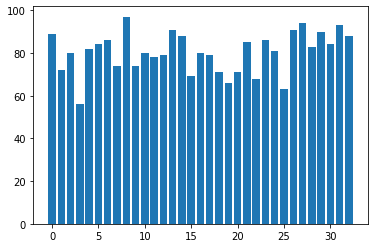

In [148]:
# no transition
test = simulate_sequences_all(100)    
plt.bar(np.arange(len(test[1][0])), test[1][0])

<BarContainer object of 85 artists>

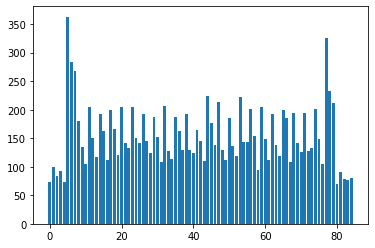

In [149]:
# one transition
plt.bar(np.arange(len(test[1][10])), test[1][10])

<BarContainer object of 178 artists>

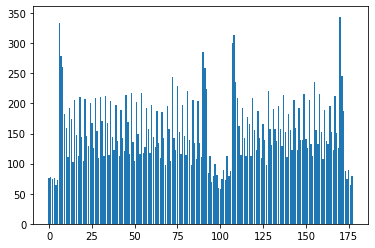

In [150]:
# two transition
plt.bar(np.arange(len(test[1][40])), test[1][40])

<BarContainer object of 271 artists>

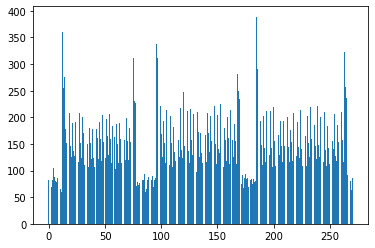

In [151]:
# three transition
plt.bar(np.arange(len(test[1][80])), test[1][80])

# Generate simulation data

In [44]:
# generate data with random seed
random.seed(0)
generated_sequences = simulate_sequences_all(3000) #GAI
RNA_data = generated_sequences[0]
observed_data = generated_sequences[1]
state_list_true = generated_sequences[2]

# shuffle data
c = list(zip(RNA_data, observed_data, state_list_true))
random.shuffle(c)
RNA_data, observed_data, state_list_true = zip(*c)


E = list(np.repeat(1, 3000)) #GAI
stop_codon_list = ['UAA', 'UGA', 'UAG']

In [45]:
# initial value
trans_prob = [{'AUG': 0.1, 'CUG': 0.2, 'GUG': 0.5}, {'AUG':0.2, 'CUG': 0.3, 'GUG': 0.1}, {'AUG':0.3, 'CUG': 0.8, 'GUG': 0.6}, {'AUG':0.4, 'CUG': 0.1, 'GUG': 0.7}]
alpha_list_prob = [np.array([ 10, 20, 18, 15, 10,  9,  8, 18, 16, 12]),
            np.array([  10, 25, 22, 20, 15, 10,  5, 22, 20, 17]),
            np.array([ 1, 5, 4, 3,  4,  3, 2, 5, 4,3])]
beta_list_prob = [beta_list_true + 2, beta_list_true * 2]

In [154]:
final_trans = []
final_alpha_list = []
final_beta_list = []

start_trans = []
start_alpha_list = []
start_beta_list = []

start = 0
count = 1
for end in range(100, 3001, 100): #GAI
    print("count " + str(count))
    
    trans_prob_copy = trans_prob.copy()
    # randomly generate index for trans
    random.seed(end)
    index = random.choice(range(4))
    trans = trans_prob_copy[index]
    start_trans.append(trans)
    
    # randomly generate index for alpha_list
    random.seed(end+1)
    index = random.choice(range(3))
    alpha_list = alpha_list_prob[index]
    start_alpha_list.append(alpha_list)
    
    # randomly generate index for beta_list
    random.seed(end+2)
    index = random.choice(range(2))
    beta_list = beta_list_prob[index]
    start_beta_list.append(beta_list)
    
    # run EM algorithm
    trans_copy = trans.copy()
    alpha_list_copy = alpha_list.copy()
    beta_list_copy = beta_list.copy()
    
    temp = EM_iter(RNA_data[start:end], observed_data[start:end], trans_copy, alpha_list_copy, beta_list_copy, 10e-10, 100)
    final_trans.append(temp[0])
    final_alpha_list.append(temp[1])
    final_beta_list.append(temp[2])
    
    start = end
    
    count += 1

count 1
[-5941.612731630414]
iteration1
defaultdict(<class 'float'>, {'AUG': 0.9708931923293583, 'CUG': 0.9742029689739963, 'GUG': 0.9585868021734035})
state1
alpha442.93446572828753
beta5.228125
state8
alpha1623.4107104009236
beta5.862500000000001
state4
alpha937.41566628982
beta6.43125
state2
alpha1168.4893342093646
beta6.2125
state7
alpha583.3255981686401
beta4.5171875
state9
alpha1344.9963064479587
beta6.125000000000001
state5
alpha1136.7474147155754
beta6.321875
state3
alpha1032.1083311114671
beta6.387500000000001
state6
alpha1014.0608407792274
beta6.43125
state10
alpha1313.5218729070841
beta6.168750000000001
[ 442 1168 1032  937 1136 1014  583 1623 1344 1313]
[5.228125  6.2125    6.3875    6.43125   6.321875  6.43125   4.5171875
 5.8625    6.125     6.16875  ]
[-5941.612731630414, -132.52235066726251]
iteration2
defaultdict(<class 'float'>, {'AUG': 0.9436288751104546, 'CUG': 0.8875205254515598, 'GUG': 0.8375791437031048})
state8
alpha1852.3297320607112
beta5.862500000000001
state

[-5591.621993805122, -156.78928168146686, -126.91886183546325, -126.91886183546325]
count 4
[-5866.662531484188]
iteration1
defaultdict(<class 'float'>, {'AUG': 0.3533358394556235, 'CUG': 0.5394641391240789, 'GUG': 0.43150445839076096})
state1
alpha857.9719168974684
beta9.312500000000004
state10
alpha2114.776958065203
beta9.750000000000002
state8
alpha2775.2845803225764
beta9.500000000000002
state6
alpha1285.1625557686916
beta8.625000000000004
state4
alpha1967.3129419716602
beta9.750000000000002
state5
alpha1599.9285921974258
beta8.093750000000004
state3
alpha2266.8246420985847
beta9.625000000000002
state9
alpha2216.553678155223
beta9.625000000000002
state7
alpha1086.4782717626333
beta8.781250000000004
state2
alpha2634.785627650466
beta9.562500000000002
[ 857 2634 2266 1967 1599 1285 1086 2775 2216 2114]
[9.3125  9.5625  9.625   9.75    8.09375 8.625   8.78125 9.5     9.625
 9.75   ]
[-5866.662531484188, -148.3062113291376]
iteration2
defaultdict(<class 'float'>, {'AUG': 0.931537761413

[-5358.11725432839, -637.6973643883916, -186.19946558572667, -114.04116958376801, -114.04116958376801]
count 7
[-4913.56742168483]
iteration1
defaultdict(<class 'float'>, {'AUG': 0.9606281284779167, 'CUG': 0.9715632618631511, 'GUG': 0.9509175870850413})
state9
alpha1392.2446854051914
beta6.081250000000001
state6
alpha1019.6897694938592
beta6.4203125000000005
state8
alpha1694.5429705488282
beta5.775
state4
alpha974.9057549702885
beta6.4750000000000005
state10
alpha1321.436935875918
beta6.125000000000001
state2
alpha1226.382448306373
beta6.168750000000001
state7
alpha582.9531888056158
beta4.528125000000001
state5
alpha1144.8732887460405
beta6.3109375000000005
state1
alpha438.4840326575411
beta5.271875
state3
alpha1086.3316227966527
beta6.300000000000001
[ 438 1226 1086  974 1144 1019  582 1694 1392 1321]
[5.271875  6.16875   6.3       6.475     6.3109375 6.4203125 4.528125
 5.775     6.08125   6.125    ]
[-4913.56742168483, -109.8496123076189]
iteration2
defaultdict(<class 'float'>, {'AU

[-4791.184975697796, -162.7600663063811, -109.78742920857052, -109.78742920857052]
count 10
[-5043.691880091804]
iteration1
defaultdict(<class 'float'>, {'AUG': 0.0779510837284308, 'CUG': 0.07060231774995787, 'GUG': 0.14179918583726078})
state6
alpha1215.9224397982002
beta8.687500000000004
state5
alpha1486.3796502216119
beta8.250000000000004
state7
alpha1242.2116290596916
beta8.625000000000004
state1
alpha1272.382058746108
beta8.648437500000004
state2
alpha1729.8563303092008
beta9.875000000000004
state10
alpha1689.3447820584302
beta7.750000000000005
state8
alpha2787.3261061448093
beta9.500000000000002
state9
alpha2231.447639322132
beta9.625000000000002
state3
alpha1222.717172400885
beta8.875000000000004
state4
alpha1055.219916448159
beta9.125000000000004
[1272 1729 1222 1055 1486 1215 1242 2787 2231 1689]
[8.6484375 9.875     8.875     9.125     8.25      8.6875    8.625
 9.5       9.625     7.75     ]
[-5043.691880091804, -599.0653391327639]
iteration2
defaultdict(<class 'float'>, {'A

[-4847.963242296202, -560.623461985612, -166.9179749664515, -105.10160758941065]
iteration4
defaultdict(<class 'float'>, {'AUG': 0.9351283774867025, 'CUG': 0.868732891596353, 'GUG': 0.8189580823776393})
state1
alpha681.0
beta8.521334228515629
state8
alpha2997.0
beta9.381250000000001
state5
alpha1668.2658732882207
beta8.348848571777348
state6
alpha1312.1327760076256
beta8.750000000000004
state4
alpha2182.4008152958654
beta8.67028271484375
state10
alpha1701.0
beta7.714843750000005
state9
alpha2367.0
beta9.384375000000002
state3
alpha2579.2342123122917
beta8.643854248046878
state7
alpha1027.485276516662
beta8.562500000000004
state2
alpha3303.0615012613307
beta9.489720703125002
[ 681 3303 2579 2182 1668 1312 1027 2997 2367 1701]
[8.52133423 9.4897207  8.64385425 8.67028271 8.34884857 8.75
 8.5625     9.38125    9.384375   7.71484375]
[-4847.963242296202, -560.623461985612, -166.9179749664515, -105.10160758941065, -105.23164815382198]
count 13
[-5398.125542528877]
iteration1
defaultdict(<cl

[-5501.771394681384]
iteration1
defaultdict(<class 'float'>, {'AUG': 0.24622162656521449, 'CUG': 0.26907837538508916, 'GUG': 0.3686428833570229})
state7
alpha1090.727432175781
beta8.781250000000004
state2
alpha2595.6952391098785
beta9.562500000000002
state10
alpha2081.937376535343
beta9.687500000000002
state3
alpha2259.9847277622393
beta9.625000000000002
state6
alpha1281.1801802278833
beta8.640625000000004
state9
alpha2191.8343211462443
beta9.750000000000002
state1
alpha927.6965615936963
beta9.218750000000004
state4
alpha1957.4123451173552
beta9.750000000000002
state8
alpha2738.9053183482106
beta9.562500000000002
state5
alpha1591.9612444784448
beta8.109375000000004
[ 927 2595 2259 1957 1591 1281 1090 2738 2191 2081]
[9.21875  9.5625   9.625    9.75     8.109375 8.640625 8.78125  9.5625
 9.75     9.6875  ]
[-5501.771394681384, -190.28062397578302]
iteration2
defaultdict(<class 'float'>, {'AUG': 0.9256773964912666, 'CUG': 0.8701612097758326, 'GUG': 0.828053908936152})
state1
alpha736.959

[-25404.447262281217, -722.2019429952283, -526.5265110743652, -317.6835221412801, -292.9811086543834]
iteration5
defaultdict(<class 'float'>, {'AUG': 0.9289855395803706, 'CUG': 0.8893098225489197, 'GUG': 0.8303719902742271})
state5
alpha1642.0
beta8.211368408203128
state2
alpha3301.0
beta9.437066894531252
state3
alpha2565.0
beta8.539711425781253
state8
alpha3018.0
beta9.440625
state4
alpha2288.0
beta9.121529785156254
state6
alpha1292.0
beta8.611481323242192
state9
alpha2397.0
beta9.625000000000002
state7
alpha1024.0
beta8.535742187500004
state10
alpha1688.0
beta7.776562500000004
state1
alpha678.0
beta8.478613281250002
[ 678 3301 2565 2288 1642 1292 1024 3018 2397 1688]
[8.47861328 9.43706689 8.53971143 9.12152979 8.21136841 8.61148132
 8.53574219 9.440625   9.625      7.7765625 ]
[-25404.447262281217, -722.2019429952283, -526.5265110743652, -317.6835221412801, -292.9811086543834, -292.9842027495749]
count 19
[-6278.7493241677985]
iteration1
defaultdict(<class 'float'>, {'AUG': 0.964289

[-4009.8297711998216, -610.5170919929623]
iteration2
defaultdict(<class 'float'>, {'AUG': 0.8630970157272275, 'CUG': 0.8250521304463588, 'GUG': 0.8167095588561575})
state4
alpha840.7389768276822
beta6.654375000000001
state10
alpha1328.0
beta6.057187500000001
state3
alpha991.1756803953389
beta6.5668750000000005
state1
alpha652.7199065562315
beta6.393105468750001
state8
alpha2129.1369007069698
beta6.653281250000001
state6
alpha993.9040609850626
beta6.541992187500002
state2
alpha1241.8401901810107
beta6.569062500000001
state7
alpha787.9451342635471
beta6.464882812500001
state5
alpha1293.132620445346
beta6.421201171875
state9
alpha1702.8219699509089
beta6.912500000000001
[ 652 1241  991  840 1293  993  787 2129 1702 1328]
[6.39310547 6.5690625  6.566875   6.654375   6.42120117 6.54199219
 6.46488281 6.65328125 6.9125     6.0571875 ]
[-4009.8297711998216, -610.5170919929623, -178.18020695482255]
iteration3
defaultdict(<class 'float'>, {'AUG': 0.9391044772343213, 'CUG': 0.9002433089764939, '

[-4240.852920143194, -642.8848991716781, -208.86946664746648, -109.9617833815055, -109.9617833815055]
count 25
[-4429.074819836356]
iteration1
defaultdict(<class 'float'>, {'AUG': 0.08849757861082735, 'CUG': 0.08158281841554137, 'GUG': 0.10065007376020482})
state9
alpha1625.648166544413
beta6.912500000000001
state6
alpha918.8486940685559
beta6.562500000000001
state7
alpha928.5651845490664
beta6.518750000000001
state4
alpha777.7232918523367
beta6.825000000000001
state1
alpha968.4356250387368
beta6.562500000000001
state8
alpha2047.3537199315263
beta6.912500000000001
state3
alpha914.071591111904
beta6.737500000000001
state5
alpha1141.8486882984078
beta6.43125
state2
alpha1202.2771877016153
beta6.825000000000001
state10
alpha1361.1101863389135
beta6.2125
[ 968 1202  914  777 1141  918  928 2047 1625 1361]
[6.5625  6.825   6.7375  6.825   6.43125 6.5625  6.51875 6.9125  6.9125
 6.2125 ]
[-4429.074819836356, -608.2286257347297]
iteration2
defaultdict(<class 'float'>, {'AUG': 0.83397520294609

[-4606.892409191509, -198.4767095343496, -126.13369592838258, -126.13369592838258]
count 28
[-5757.402166131447]
iteration1
defaultdict(<class 'float'>, {'AUG': 0.3338801101160774, 'CUG': 0.5602277842343419, 'GUG': 0.43520910295286636})
state6
alpha1282.070139169189
beta8.640625000000004
state8
alpha2823.3266600622014
beta9.500000000000002
state2
alpha2667.853613629321
beta9.625000000000002
state10
alpha2087.8138979366836
beta9.687500000000002
state9
alpha2247.979768277818
beta9.625000000000002
state7
alpha1078.3329408244283
beta8.812500000000004
state3
alpha2301.4418297408547
beta9.625000000000002
state1
alpha852.3050368886666
beta9.343750000000004
state4
alpha1985.0357688802262
beta9.750000000000002
state5
alpha1597.411823535461
beta8.109375000000004
[ 852 2667 2301 1985 1597 1282 1078 2823 2247 2087]
[9.34375  9.625    9.625    9.75     8.109375 8.640625 8.8125   9.5
 9.625    9.6875  ]
[-5757.402166131447, -156.80881947091143]
iteration2
defaultdict(<class 'float'>, {'AUG': 0.93222

[-4399.269084665801, -163.62659610865774, -113.19770447573664, -113.19770447573664]


In [155]:
start_trans

[{'AUG': 0.2, 'CUG': 0.3, 'GUG': 0.1},
 {'AUG': 0.1, 'CUG': 0.2, 'GUG': 0.5},
 {'AUG': 0.3, 'CUG': 0.8, 'GUG': 0.6},
 {'AUG': 0.3, 'CUG': 0.8, 'GUG': 0.6},
 {'AUG': 0.4, 'CUG': 0.1, 'GUG': 0.7},
 {'AUG': 0.3, 'CUG': 0.8, 'GUG': 0.6},
 {'AUG': 0.2, 'CUG': 0.3, 'GUG': 0.1},
 {'AUG': 0.4, 'CUG': 0.1, 'GUG': 0.7},
 {'AUG': 0.2, 'CUG': 0.3, 'GUG': 0.1},
 {'AUG': 0.4, 'CUG': 0.1, 'GUG': 0.7},
 {'AUG': 0.1, 'CUG': 0.2, 'GUG': 0.5},
 {'AUG': 0.3, 'CUG': 0.8, 'GUG': 0.6},
 {'AUG': 0.3, 'CUG': 0.8, 'GUG': 0.6},
 {'AUG': 0.2, 'CUG': 0.3, 'GUG': 0.1},
 {'AUG': 0.3, 'CUG': 0.8, 'GUG': 0.6},
 {'AUG': 0.1, 'CUG': 0.2, 'GUG': 0.5},
 {'AUG': 0.4, 'CUG': 0.1, 'GUG': 0.7},
 {'AUG': 0.3, 'CUG': 0.8, 'GUG': 0.6},
 {'AUG': 0.1, 'CUG': 0.2, 'GUG': 0.5},
 {'AUG': 0.4, 'CUG': 0.1, 'GUG': 0.7},
 {'AUG': 0.3, 'CUG': 0.8, 'GUG': 0.6},
 {'AUG': 0.3, 'CUG': 0.8, 'GUG': 0.6},
 {'AUG': 0.4, 'CUG': 0.1, 'GUG': 0.7},
 {'AUG': 0.1, 'CUG': 0.2, 'GUG': 0.5},
 {'AUG': 0.1, 'CUG': 0.2, 'GUG': 0.5},
 {'AUG': 0.4, 'CUG': 0.1,

In [156]:
start_alpha_list

[array([1, 5, 4, 3, 4, 3, 2, 5, 4, 3]),
 array([10, 20, 18, 15, 10,  9,  8, 18, 16, 12]),
 array([10, 25, 22, 20, 15, 10,  5, 22, 20, 17]),
 array([10, 25, 22, 20, 15, 10,  5, 22, 20, 17]),
 array([1, 5, 4, 3, 4, 3, 2, 5, 4, 3]),
 array([10, 20, 18, 15, 10,  9,  8, 18, 16, 12]),
 array([1, 5, 4, 3, 4, 3, 2, 5, 4, 3]),
 array([10, 20, 18, 15, 10,  9,  8, 18, 16, 12]),
 array([10, 25, 22, 20, 15, 10,  5, 22, 20, 17]),
 array([10, 20, 18, 15, 10,  9,  8, 18, 16, 12]),
 array([10, 25, 22, 20, 15, 10,  5, 22, 20, 17]),
 array([10, 20, 18, 15, 10,  9,  8, 18, 16, 12]),
 array([10, 25, 22, 20, 15, 10,  5, 22, 20, 17]),
 array([1, 5, 4, 3, 4, 3, 2, 5, 4, 3]),
 array([1, 5, 4, 3, 4, 3, 2, 5, 4, 3]),
 array([10, 25, 22, 20, 15, 10,  5, 22, 20, 17]),
 array([10, 25, 22, 20, 15, 10,  5, 22, 20, 17]),
 array([10, 20, 18, 15, 10,  9,  8, 18, 16, 12]),
 array([1, 5, 4, 3, 4, 3, 2, 5, 4, 3]),
 array([1, 5, 4, 3, 4, 3, 2, 5, 4, 3]),
 array([1, 5, 4, 3, 4, 3, 2, 5, 4, 3]),
 array([10, 20, 18, 15, 10,  9

In [157]:
start_beta_list

[array([7., 7., 7., 7., 7., 7., 7., 7., 7., 7.]),
 array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.]),
 array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.]),
 array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.]),
 array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.]),
 array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.]),
 array([7., 7., 7., 7., 7., 7., 7., 7., 7., 7.]),
 array([7., 7., 7., 7., 7., 7., 7., 7., 7., 7.]),
 array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.]),
 array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.]),
 array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.]),
 array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.]),
 array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.]),
 array([7., 7., 7., 7., 7., 7., 7., 7., 7., 7.]),
 array([7., 7., 7., 7., 7., 7., 7., 7., 7., 7.]),
 array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.]),
 array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.]),
 array([10., 10., 10., 10., 10

In [158]:
final_trans

[defaultdict(float,
             {'AUG': 0.9436288751104546,
              'CUG': 0.8875205254515598,
              'GUG': 0.8375791437031048}),
 defaultdict(float,
             {'AUG': 0.9336633419389592,
              'CUG': 0.8940632275826651,
              'GUG': 0.8186538258444022}),
 defaultdict(float,
             {'AUG': 0.9294883803095942,
              'CUG': 0.896539396587987,
              'GUG': 0.8352450957470026}),
 defaultdict(float,
             {'AUG': 0.9311228750789124,
              'CUG': 0.8964597630216057,
              'GUG': 0.8254168331141923}),
 defaultdict(float,
             {'AUG': 0.935144079208159,
              'CUG': 0.8928657651252884,
              'GUG': 0.8318002328352453}),
 defaultdict(float,
             {'AUG': 0.9305371835278852,
              'CUG': 0.8891395509233214,
              'GUG': 0.8285875295448553}),
 defaultdict(float,
             {'AUG': 0.9373608002479029,
              'CUG': 0.909319170464544,
              'GUG': 0.84087875

In [159]:
final_alpha_list

[array([ 418, 2153, 1905, 1580, 1263,  963,  542, 1852, 1518, 1334]),
 array([ 679, 3264, 2572, 2187, 1656, 1311, 1038, 2987, 2323, 1704]),
 array([ 748, 3239, 2821, 2395, 1620, 1294, 1057, 3020, 2420, 2097]),
 array([ 745, 3268, 2834, 2401, 1620, 1293, 1055, 3020, 2394, 2114]),
 array([ 501, 2794, 2456, 2042, 1617, 1247,  622, 2280, 1900, 1645]),
 array([ 679, 3293, 2568, 2175, 1648, 1308, 1024, 2978, 2301, 1709]),
 array([ 421, 2148, 1836, 1597, 1260,  963,  543, 1851, 1517, 1321]),
 array([ 513, 2267, 1936, 1629, 1273,  988,  781, 2198, 1681, 1362]),
 array([ 740, 3307, 2836, 2422, 1620, 1292, 1052, 3029, 2283, 2082]),
 array([ 678, 3351, 2473, 2185, 1651, 1301, 1036, 3030, 2405, 1689]),
 array([ 737, 3277, 2830, 2437, 1621, 1293, 1051, 3034, 2390, 2117]),
 array([ 681, 2609, 2052, 1753, 1685, 1328, 1040, 2997, 2367, 1701]),
 array([ 746, 3306, 2854, 2404, 1619, 1293, 1056, 3026, 2401, 2123]),
 array([ 421, 2173, 1849, 1571, 1263,  966,  539, 1857, 1520, 1321]),
 array([ 420, 2122, 

In [160]:
final_beta_list

[array([5.228125  , 6.17367188, 6.34757813, 6.27046875, 6.321875  ,
        6.42120117, 4.5171875 , 5.8625    , 6.0484375 , 6.01453125]),
 array([8.47861328, 9.32276184, 8.53684863, 8.68054688, 8.28654373,
        8.7362854 , 8.66035156, 9.37851563, 9.2640625 , 7.66662598]),
 array([9.375     , 9.37234375, 9.32421875, 9.5671875 , 8.09375   ,
        8.625     , 8.8125    , 9.5       , 9.75      , 9.4453125 ]),
 array([9.3125    , 9.3234375 , 9.384375  , 9.628125  , 8.09375   ,
        8.625     , 8.78125   , 9.440625  , 9.56484375, 9.628125  ]),
 array([6.25      , 7.97265625, 8.1984375 , 8.11458984, 8.09375   ,
        8.3125    , 5.1953125 , 7.2046875 , 7.6046875 , 7.459375  ]),
 array([8.47861328, 9.44682617, 8.54496094, 8.67302734, 8.23710938,
        8.72265625, 8.53574219, 9.26128418, 9.26143066, 7.71514893]),
 array([5.271875  , 6.13019531, 6.1425    , 6.35359375, 6.3109375 ,
        6.4203125 , 4.5210498 , 5.73890625, 6.08125   , 5.971875  ]),
 array([6.40376953, 6.44482617, 6.

In [161]:
differ_state(RNA_data, observed_data, start_alpha_list, start_beta_list, E, start_trans, stop_codon_list, state_list_true)

[5581,
 15883,
 1811,
 1666,
 5485,
 15803,
 5102,
 16422,
 2071,
 15150,
 2359,
 14516,
 1459,
 5316,
 5387,
 2563,
 1630,
 16838,
 5765,
 5281,
 6197,
 15528,
 1584,
 15306,
 16506,
 5319,
 2201,
 1456,
 16254,
 2473]

In [162]:
differ_state(RNA_data, observed_data, final_alpha_list, final_beta_list, E, final_trans, stop_codon_list, state_list_true)

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [54]:
alpha_name_list = []
for i in range(1, 11):
    alpha_name_list.append(str(i))
    
beta_name_list = []
for i in range(1, 11):
    beta_name_list.append(str(i))



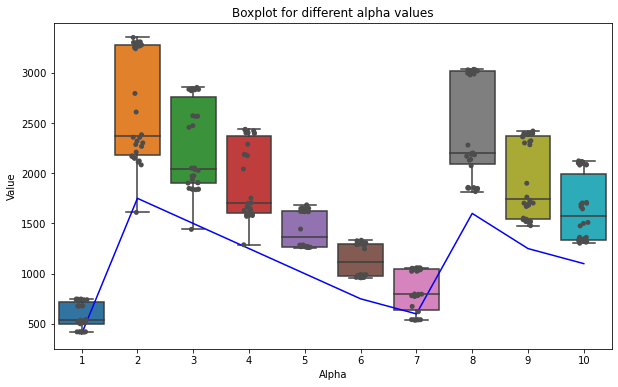

In [55]:
# construct final alpha dataframe
final_alpha_df = pd.DataFrame(final_alpha_list, columns=alpha_name_list)

fig, ax = plt.subplots(figsize = (10,6))
sns.boxplot(data=final_alpha_df)
sns.stripplot(data=final_alpha_df, color=".3", size=5)

locs=ax.get_xticks()
ax.plot(locs, alpha_list_true, 'b-')

# label
plt.xlabel('Alpha')
plt.ylabel('Value')
#plt.rc('xtick',labelsize = 15)
#plt.rc('ytick',labelsize = 15)
plt.title('Boxplot for different alpha values') 
fig.savefig("Boxplot for different alpha values")

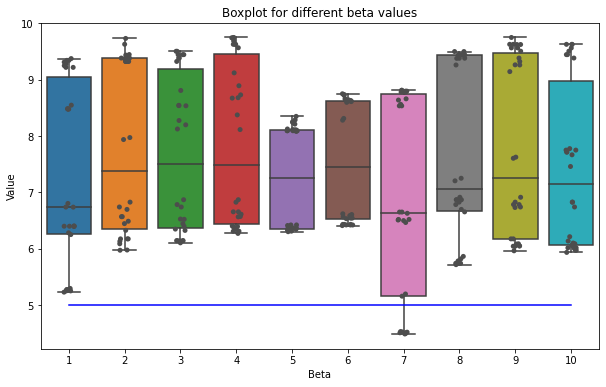

In [56]:
# construct final beta dataframe
final_beta_df = pd.DataFrame(final_beta_list, columns=beta_name_list)

fig, ax = plt.subplots(figsize = (10,6))
sns.boxplot(data=final_beta_df)
sns.stripplot(data=final_beta_df, color=".3", size=5)

locs=ax.get_xticks()
ax.plot(locs, beta_list_true, 'b-')

# label
plt.xlabel('Beta')
plt.ylabel('Value')
#plt.rc('xtick',labelsize = 12)
#plt.rc('ytick',labelsize = 12)
plt.title('Boxplot for different beta values') 
fig.savefig("Boxplot for different beta values")


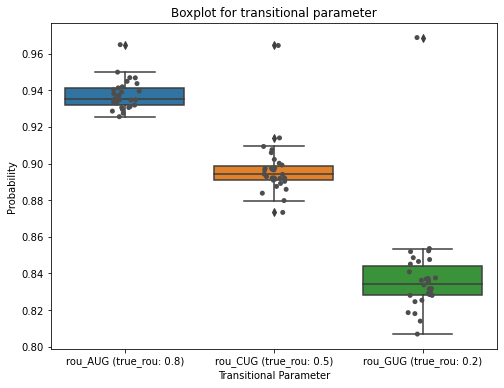

In [60]:
rou_AUG = []
rou_CUG = []
rou_GUG = []
for element in final_trans:
    rou_AUG.append(element['AUG'])
    rou_CUG.append(element['CUG'])
    rou_GUG.append(element['GUG'])
    
final_trans_df = pd.DataFrame({"rou_AUG (true_rou: 0.8)":rou_AUG, "rou_CUG (true_rou: 0.5)":rou_CUG, "rou_GUG (true_rou: 0.2)":rou_GUG}, columns=['rou_AUG (true_rou: 0.8)', "rou_CUG (true_rou: 0.5)", "rou_GUG (true_rou: 0.2)"])

fig, ax = plt.subplots(figsize = (8, 6))
sns.boxplot(data=final_trans_df)
sns.stripplot(data=final_trans_df, color=".3", size=5)


# plt.plot([0.8, 0.5, 0.2], color='r', linestyle='-')

plt.xlabel('Transitional Parameter')
plt.ylabel('Probability')
plt.title('Boxplot for transitional parameter') 
fig.savefig("Boxplot for transitional parameter")

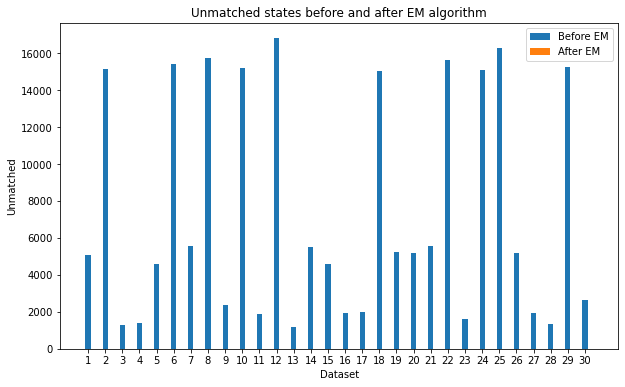

In [61]:
before = differ_state(RNA_data, observed_data, start_alpha_list, start_beta_list, E, start_trans, stop_codon_list, state_list_true)
after = differ_state(RNA_data, observed_data, final_alpha_list, final_beta_list, E, final_trans, stop_codon_list, state_list_true)

# plot
fig, ax = plt.subplots(figsize = (10,6))
plt.xticks(np.arange(1, 31, 1))
ind = np.arange(1, 31, 1)
width = 0.3

# label
plt.bar(ind, before, width, label = 'Before EM')
plt.bar(ind + width, after, width, label = 'After EM') 
plt.xlabel('Dataset')
plt.ylabel('Unmatched')
#plt.rc('xtick',labelsize = 12)
#plt.rc('ytick',labelsize = 12)
plt.title('Unmatched states before and after EM algorithm') 
plt.legend(loc = 'best')
fig.savefig("Unmatched states before and after EM algorithm")

In [173]:
percent(RNA_data, observed_data, start_alpha_list, start_beta_list, E, start_trans, stop_codon_list, False, state_list_true, 'AUG')

[0.6823529411764706,
 0.7071823204419889,
 0.7358490566037735,
 0.7340425531914894,
 0.6534090909090909,
 0.7204301075268817,
 0.6829268292682927,
 0.6839080459770115,
 0.6848484848484848,
 0.6688311688311688,
 0.664804469273743,
 0.6647398843930635,
 0.71875,
 0.7705882352941177,
 0.6542553191489362,
 0.6910112359550562,
 0.6842105263157895,
 0.6941176470588235,
 0.7735849056603774,
 0.7058823529411765,
 0.7814569536423841,
 0.6818181818181818,
 0.7619047619047619,
 0.703030303030303,
 0.7189189189189189,
 0.7417218543046358,
 0.725,
 0.7349397590361446,
 0.6746987951807228]

In [174]:
percent(RNA_data, observed_data, start_alpha_list, start_beta_list, E, start_trans, stop_codon_list, False, state_list_true, 'CUG')

[0.38071065989847713,
 0.41509433962264153,
 0.4557823129251701,
 0.4027777777777778,
 0.48333333333333334,
 0.4186046511627907,
 0.5060240963855421,
 0.48502994011976047,
 0.45625,
 0.4835164835164835,
 0.5064935064935064,
 0.3701657458563536,
 0.49079754601226994,
 0.423728813559322,
 0.5123456790123457,
 0.40425531914893614,
 0.49079754601226994,
 0.42857142857142855,
 0.42857142857142855,
 0.4696132596685083,
 0.5080213903743316,
 0.5166666666666667,
 0.45294117647058824,
 0.4124293785310734,
 0.422360248447205,
 0.47101449275362317,
 0.4426229508196721,
 0.46994535519125685,
 0.4484536082474227]

In [175]:
percent(RNA_data, observed_data, start_alpha_list, start_beta_list, E, start_trans, stop_codon_list, False, state_list_true, 'GUG')

[0.18781725888324874,
 0.19473684210526315,
 0.18072289156626506,
 0.15789473684210525,
 0.18128654970760233,
 0.1388888888888889,
 0.18823529411764706,
 0.21637426900584794,
 0.20279720279720279,
 0.16666666666666666,
 0.20610687022900764,
 0.14835164835164835,
 0.14965986394557823,
 0.14285714285714285,
 0.19480519480519481,
 0.1901840490797546,
 0.16129032258064516,
 0.23809523809523808,
 0.18285714285714286,
 0.20398009950248755,
 0.13496932515337423,
 0.17261904761904762,
 0.16304347826086957,
 0.16393442622950818,
 0.15942028985507245,
 0.17613636363636365,
 0.17532467532467533,
 0.17567567567567569,
 0.17435897435897435]

In [62]:
actual_percentage = percent(RNA_data, observed_data, start_alpha_list, start_beta_list, E, start_trans, stop_codon_list, False, state_list_true, 'AUG')
previous_percentage = percent(RNA_data, observed_data, start_alpha_list, start_beta_list, E, start_trans, stop_codon_list, True, state_list_true, 'AUG')
estimated_percentage = percent(RNA_data, observed_data, final_alpha_list, final_beta_list, E, final_trans, stop_codon_list, True, state_list_true, 'AUG')

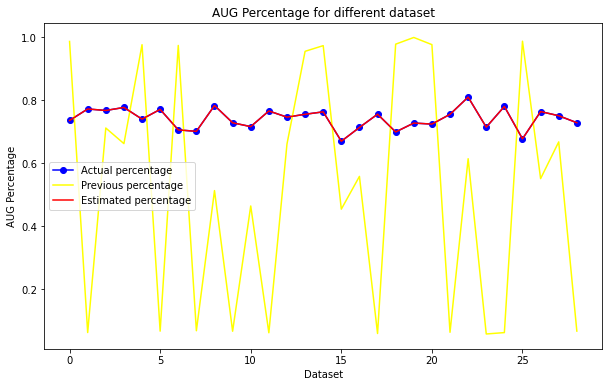

In [63]:
fig, ax = plt.subplots(figsize = (10,6))
plt.plot(actual_percentage, color = 'blue', marker = 'o', label = 'Actual percentage')
plt.plot(previous_percentage, color = 'yellow', label = 'Previous percentage')
plt.plot(estimated_percentage, color = 'red', label = 'Estimated percentage')
plt.legend()
plt.title('AUG Percentage for different dataset')
plt.xlabel('Dataset')
plt.ylabel('AUG Percentage')
plt.show()
fig.savefig('AUG Percentage for different dataset')

In [64]:
actual_percentage = percent(RNA_data, observed_data, start_alpha_list, start_beta_list, E, start_trans, stop_codon_list, False, state_list_true, 'CUG')
previous_percentage = percent(RNA_data, observed_data, start_alpha_list, start_beta_list, E, start_trans, stop_codon_list, True, state_list_true, 'CUG')
estimated_percentage = percent(RNA_data, observed_data, final_alpha_list, final_beta_list, E, final_trans, stop_codon_list, True, state_list_true, 'CUG')

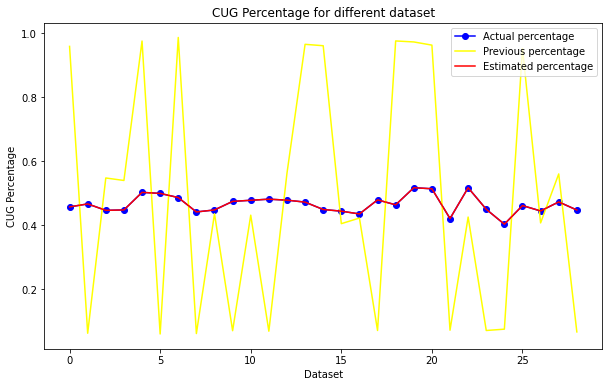

In [65]:
fig, ax = plt.subplots(figsize = (10,6))
plt.plot(actual_percentage, color = 'blue', marker = 'o', label = 'Actual percentage')
plt.plot(previous_percentage, color = 'yellow', label = 'Previous percentage')
plt.plot(estimated_percentage, color = 'red', label = 'Estimated percentage')
plt.legend()
plt.title('CUG Percentage for different dataset')
plt.xlabel('Dataset')
plt.ylabel('CUG Percentage')
plt.show()
fig.savefig('CUG Percentage for different dataset')

In [66]:
actual_percentage = percent(RNA_data, observed_data, start_alpha_list, start_beta_list, E, start_trans, stop_codon_list, False, state_list_true, 'GUG')
previous_percentage = percent(RNA_data, observed_data, start_alpha_list, start_beta_list, E, start_trans, stop_codon_list, True, state_list_true, 'GUG')
estimated_percentage = percent(RNA_data, observed_data, final_alpha_list, final_beta_list, E, final_trans, stop_codon_list, True, state_list_true, 'GUG')

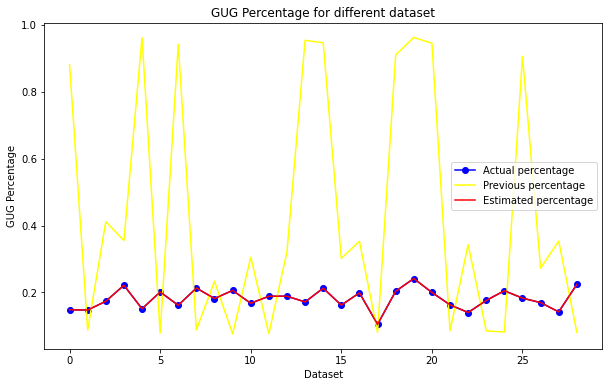

In [67]:
fig, ax = plt.subplots(figsize = (10,6))
plt.plot(actual_percentage, color = 'blue', marker = 'o', label = 'Actual percentage')
plt.plot(previous_percentage, color = 'yellow', label = 'Previous percentage')
plt.plot(estimated_percentage, color = 'red', label = 'Estimated percentage')
plt.legend()
plt.title('GUG Percentage for different dataset')
plt.xlabel('Dataset')
plt.ylabel('GUG Percentage')
plt.show()
fig.savefig('GUG Percentage for different dataset')

In [293]:
alpha_list_true

array([ 400., 1750., 1500., 1250., 1000.,  750.,  600., 1600., 1250.,
       1100.])

# beta fixed

In [182]:
def EM_iter(RNA_data, observed_data, trans_init, alpha_init, beta_init, epsilon, max_iter):
    
    trans = trans_init.copy()
    alpha_list = alpha_init.copy()
    beta_list = beta_init
    
    forward = forward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)
    backward = backward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)  
    
    log_links = []
    log_links.append(incomplete_log_likelihood(forward, observed_data, alpha_init, beta_init, E))
    
    delta = 1
    n_iter = 1
    print(log_links)
    while((delta > epsilon) and (n_iter < max_iter)):
        print("iteration" + str(n_iter))
        #forward = forward_matrix(RNA_data, observed_data, x, beta_list, E, trans, stop_codon_list)
        #backward = backward_matrix(RNA_data, observed_data, x, beta_list, E, trans, stop_codon_list)
        curr_trans = trans.copy()
        curr_alpha_list = alpha_list.copy()
        #curr_beta_list = beta_list.copy()
       
        L = compute_L(forward, backward)
        
        #update rho_u_ci, rho_ci, delta_ci
        trans = update_parameter(forward, backward, RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)
        print(trans)
        
        # alpha_list
        state_list = np.arange(10)+1
        random.shuffle(state_list)
        
        for i in state_list:
            state = i
           
            print("state"+str(state))
            res = minimize(object_function_alpha, alpha_list[state-1], method='BFGS', tol = 1, jac=derivative_function_alpha, args = (state, forward, observed_data, beta_list, E, L), options={'disp': False, 'maxiter': 10,'gtol': 1})
            alpha_list[state-1] = res.x[0]
            print("alpha"+str(res.x[0]))
            
            #res = minimize(object_function_beta, beta_list[state-1], method='nelder-mead', tol = 1, args = (state, forward, observed_data, alpha_list, E, L), options={'disp': False})
            #beta_list[state-1] = res.x[0]
            #print("beta"+str(res.x[0]))
           
            
        
        print(alpha_list)
        #print(beta_list)

        
        forward = forward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)
        backward = backward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)  
        
        # log likelihood
        log_links.append(incomplete_log_likelihood(forward, observed_data, alpha_list, beta_list, E))
        delta = log_links[-1] - log_links[-2]
        n_iter += 1
        
        print(log_links)


    if (delta < 0):
        trans = curr_trans
        alpha_list = curr_alpha_list
        #beta_list = curr_beta_list
        
    return (trans, alpha_list)

In [183]:
# initial value
trans_prob = [{'AUG': 0.1, 'CUG': 0.2, 'GUG': 0.5}, {'AUG':0.2, 'CUG': 0.3, 'GUG': 0.1}, {'AUG':0.3, 'CUG': 0.8, 'GUG': 0.6}, {'AUG':0.4, 'CUG': 0.1, 'GUG': 0.7}]
alpha_list_prob = [np.array([ 10, 20, 18, 15, 10,  9,  8, 18, 16, 12]),
            np.array([  10, 25, 22, 20, 15, 10,  5, 22, 20, 17]),
            np.array([ 1, 5, 4, 3,  4,  3, 2, 5, 4,3])]

In [184]:
final_trans_beta_fixed = []
final_alpha_list_beta_fixed = []
#final_beta_list = []

start_trans_beta_fixed = []
start_alpha_list_beta_fixed = []
#start_beta_list = []

start = 0
count = 1
for end in range(100, 3001, 100): #GAI
    print("count " + str(count))
    
    trans_prob_copy = trans_prob.copy()
    # randomly generate index for trans
    random.seed(end)
    index = random.choice(range(4))
    trans = trans_prob_copy[index]
    start_trans_beta_fixed.append(trans)
    
    # randomly generate index for alpha_list
    random.seed(end+1)
    index = random.choice(range(3))
    alpha_list = alpha_list_prob[index]
    start_alpha_list_beta_fixed.append(alpha_list)
    
    # randomly generate index for beta_list
    #random.seed(end+2)
    #index = random.choice(range(2))
    #beta_list = beta_list_prob[index]
    #start_beta_list.append(beta_list)
    
    # run EM algorithm
    trans_copy = trans.copy()
    alpha_list_copy = alpha_list.copy()
    #beta_list_copy = beta_list.copy()
    
    temp = EM_iter(RNA_data[start:end], observed_data[start:end], trans_copy, alpha_list_copy, beta_list_true, 10e-10, 100)
    final_trans_beta_fixed.append(temp[0])
    final_alpha_list_beta_fixed.append(temp[1])
    #final_beta_list.append(temp[2])
    
    start = end
    
    count += 1

count 1
[-5122.036860690676]
iteration1
defaultdict(<class 'float'>, {'AUG': 0.9710066740125035, 'CUG': 0.9744907942662018, 'GUG': 0.9587325353741155})
state7
alpha492.5122448648456
state8
alpha1268.5690666010125
state3
alpha768.8026736614939
state2
alpha875.9099289446804
state5
alpha860.7449564813045
state1
alpha359.5744895615019
state10
alpha1008.6016858777843
state6
alpha761.2598216936243
state9
alpha1031.9425997802218
state4
alpha695.9946244708367
[ 359  875  768  695  860  761  492 1268 1031 1008]
[-5122.036860690676, -139.0508242480435]
iteration2
defaultdict(<class 'float'>, {'AUG': 0.9489520939952399, 'CUG': 0.8899835796338961, 'GUG': 0.8414539831584151})
state2
alpha1731.9118021844788
state6
alpha750.3689801098708
state10
alpha1105.5338976672956
state7
alpha599.9851870866563
state1
alpha400.6954009308173
state9
alpha1244.2323613740398
state3
alpha1492.4461848614726
state4
alpha1233.7856432004658
state8
alpha1578.714822885611
state5
alpha998.847947761129
[ 400 1731 1492 1233  9

[-4808.114284742345, -136.97593543262016, -121.0654788691635, -120.97600033657855]
iteration4
defaultdict(<class 'float'>, {'AUG': 0.9357903025293777, 'CUG': 0.8928882902208944, 'GUG': 0.8321199217071001})
state6
alpha750.0
state3
alpha1496.0
state4
alpha1234.0
state7
alpha599.0
state9
alpha1230.0
state5
alpha999.0
state8
alpha1551.0
state10
alpha1071.0
state1
alpha401.0
state2
alpha1739.0
[ 401 1739 1496 1234  999  750  599 1551 1230 1071]
[-4808.114284742345, -136.97593543262016, -121.0654788691635, -120.97600033657855, -120.97600033657855]
count 6
[-3819.0998427358077]
iteration1
defaultdict(<class 'float'>, {'AUG': 0.07682147354776783, 'CUG': 0.09578030806487543, 'GUG': 0.1280374093788508})
state2
alpha880.2428436215033
state3
alpha667.7352880978088
state7
alpha702.0298923450983
state5
alpha877.5761776460066
state6
alpha687.5242889262222
state4
alpha577.7024921767417
state8
alpha1472.5289438327409
state1
alpha715.5166893859325
state9
alpha1097.605469654555
state10
alpha1039.0054654

alpha1095.7950673061086
state8
alpha1460.7472675214935
state7
alpha696.5670728074788
state2
alpha870.7886203908732
state4
alpha569.1226775190854
[ 715  870  677  569  868  682  696 1460 1095 1023]
[-3595.6730189056216, -522.9660189226546]
iteration2
defaultdict(<class 'float'>, {'AUG': 0.8865441609151818, 'CUG': 0.8610847529176885, 'GUG': 0.7957484886983465})
state5
alpha1005.9159518021529
state7
alpha609.7435079638776
state3
alpha834.0547879386293
state2
alpha1011.3691017470605
state9
alpha1244.3180028658605
state6
alpha757.7272721479358
state8
alpha1596.8631993367514
state1
alpha458.8488977178849
state4
alpha697.2423005016011
state10
alpha1086.849852771813
[ 458 1011  834  697 1005  757  609 1596 1244 1086]
[-3595.6730189056216, -522.9660189226546, -127.2377698194947]
iteration3
defaultdict(<class 'float'>, {'AUG': 0.9456489420391888, 'CUG': 0.8944661238172391, 'GUG': 0.8186274503370914})
state4
alpha1230.5061646244258
state5
alpha1001.6006866286866
state8
alpha1596.0
state3
alpha145

alpha1087.0
state5
alpha1001.0
state1
alpha399.0
state4
alpha1226.0
state6
alpha751.0
state3
alpha1508.0
state2
alpha1748.0
state8
alpha1572.0
state7
alpha600.0100000000006
state9
alpha1239.0
[ 399 1748 1508 1226 1001  751  600 1572 1239 1087]
[-4298.525334974236, -124.65892006504941, -112.0730823757089, -112.0730823757089]
count 15
[-5358.731432185574]
iteration1
defaultdict(<class 'float'>, {'AUG': 0.9716211281305379, 'CUG': 0.968854400006368, 'GUG': 0.9660908147216608})
state9
alpha1054.285700883729
state2
alpha899.409085727492
state10
alpha1000.249909671867
state6
alpha765.1166545942021
state8
alpha1289.1174280829136
state5
alpha869.492715740907
state1
alpha355.6815654311123
state3
alpha803.3715890791246
state7
alpha494.05611958192384
state4
alpha726.9842046698712
[ 355  899  803  726  869  765  494 1289 1054 1000]
[-5358.731432185574, -161.79707094935924]
iteration2
defaultdict(<class 'float'>, {'AUG': 0.9387347525954541, 'CUG': 0.9199181870099891, 'GUG': 0.8731708909730993})
stat

alpha494.61268142782205
state4
alpha722.334334233138
state10
alpha1027.8673150480943
state1
alpha358.48600362343274
state3
alpha804.64704741909
state5
alpha858.8621762696771
state9
alpha1086.0151005742737
state8
alpha1339.743658179363
state6
alpha769.3353829047004
state2
alpha898.6000153270779
[ 358  898  804  722  858  769  494 1339 1086 1027]
[-5412.666537819208, -152.91233823927294]
iteration2
defaultdict(<class 'float'>, {'AUG': 0.9580473455138001, 'CUG': 0.9074650077760498, 'GUG': 0.8575843842070393})
state2
alpha1743.6750012400773
state4
alpha1243.2725578251664
state7
alpha600.7030619819778
state9
alpha1237.5204436196761
state10
alpha1091.7979673450004
state1
alpha400.9329956951443
state6
alpha748.3607071335565
state3
alpha1498.3405824224553
state8
alpha1578.9590076404868
state5
alpha998.61467264961
[ 400 1743 1498 1243  998  748  600 1578 1237 1091]
[-5412.666537819208, -152.91233823927294, -136.20328706661755]
iteration3
defaultdict(<class 'float'>, {'AUG': 0.9470985842881627, 

alpha1589.2841729355941
state7
alpha598.8391393599592
state6
alpha749.7417056949229
state3
alpha1495.5145871577793
state4
alpha1235.6210616744577
state10
alpha1089.7548405412638
state2
alpha1731.454038372327
state5
alpha999.3503621961105
state9
alpha1236.7908798740646
state1
alpha399.79088661450703
[ 399 1731 1495 1235  999  749  598 1589 1236 1089]
[-3650.087970408387, -131.5570635570525, -106.98635291997459]
iteration3
defaultdict(<class 'float'>, {'AUG': 0.9402307545034103, 'CUG': 0.8917418699325619, 'GUG': 0.8279961757911516})
state4
alpha1235.0
state5
alpha999.0
state7
alpha599.010000000003
state6
alpha749.0
state2
alpha1731.0
state8
alpha1589.0
state1
alpha399.0
state3
alpha1495.0
state10
alpha1089.0
state9
alpha1236.0
[ 399 1731 1495 1235  999  749  599 1589 1236 1089]
[-3650.087970408387, -131.5570635570525, -106.98635291997459, -106.98635291997459]
count 24
[-3559.499573629955]
iteration1
defaultdict(<class 'float'>, {'AUG': 0.08416895945966821, 'CUG': 0.08095304992399892, 'GU

alpha1350.3123072469543
state9
alpha1140.6331748282846
state10
alpha1028.4992934231468
state3
alpha1161.5152213102292
state5
alpha949.6625578893735
state8
alpha1474.43270594455
state4
alpha999.5970627981662
state7
alpha601.9888940618998
state6
alpha726.7941360623723
state1
alpha450.6674623569283
[ 450 1350 1161  999  949  726  601 1474 1140 1028]
[-4101.586342545202, -150.50716312343422]
iteration2
defaultdict(<class 'float'>, {'AUG': 0.9331709311439531, 'CUG': 0.8981287280711295, 'GUG': 0.8473848541934073})
state3
alpha1491.5491052199372
state4
alpha1232.8632685701332
state2
alpha1733.1465635036895
state9
alpha1241.7722397411635
state5
alpha999.0938937066545
state7
alpha601.0
state10
alpha1094.9963791800383
state6
alpha748.2182384395406
state8
alpha1597.8647372346556
state1
alpha400.63764973724176
[ 400 1733 1491 1232  999  748  601 1597 1241 1094]
[-4101.586342545202, -150.50716312343422, -131.88490356338744]
iteration3
defaultdict(<class 'float'>, {'AUG': 0.9318991863123509, 'CUG': 

In [185]:
start_trans_beta_fixed

[{'AUG': 0.2, 'CUG': 0.3, 'GUG': 0.1},
 {'AUG': 0.1, 'CUG': 0.2, 'GUG': 0.5},
 {'AUG': 0.3, 'CUG': 0.8, 'GUG': 0.6},
 {'AUG': 0.3, 'CUG': 0.8, 'GUG': 0.6},
 {'AUG': 0.4, 'CUG': 0.1, 'GUG': 0.7},
 {'AUG': 0.3, 'CUG': 0.8, 'GUG': 0.6},
 {'AUG': 0.2, 'CUG': 0.3, 'GUG': 0.1},
 {'AUG': 0.4, 'CUG': 0.1, 'GUG': 0.7},
 {'AUG': 0.2, 'CUG': 0.3, 'GUG': 0.1},
 {'AUG': 0.4, 'CUG': 0.1, 'GUG': 0.7},
 {'AUG': 0.1, 'CUG': 0.2, 'GUG': 0.5},
 {'AUG': 0.3, 'CUG': 0.8, 'GUG': 0.6},
 {'AUG': 0.3, 'CUG': 0.8, 'GUG': 0.6},
 {'AUG': 0.2, 'CUG': 0.3, 'GUG': 0.1},
 {'AUG': 0.3, 'CUG': 0.8, 'GUG': 0.6},
 {'AUG': 0.1, 'CUG': 0.2, 'GUG': 0.5},
 {'AUG': 0.4, 'CUG': 0.1, 'GUG': 0.7},
 {'AUG': 0.3, 'CUG': 0.8, 'GUG': 0.6},
 {'AUG': 0.1, 'CUG': 0.2, 'GUG': 0.5},
 {'AUG': 0.4, 'CUG': 0.1, 'GUG': 0.7},
 {'AUG': 0.3, 'CUG': 0.8, 'GUG': 0.6},
 {'AUG': 0.3, 'CUG': 0.8, 'GUG': 0.6},
 {'AUG': 0.4, 'CUG': 0.1, 'GUG': 0.7},
 {'AUG': 0.1, 'CUG': 0.2, 'GUG': 0.5},
 {'AUG': 0.1, 'CUG': 0.2, 'GUG': 0.5},
 {'AUG': 0.4, 'CUG': 0.1,

In [187]:
final_trans_beta_fixed

[defaultdict(float,
             {'AUG': 0.9489520939952399,
              'CUG': 0.8899835796338961,
              'GUG': 0.8414539831584151}),
 defaultdict(float,
             {'AUG': 0.9293406942479356,
              'CUG': 0.8905539360627752,
              'GUG': 0.8161893879777833}),
 defaultdict(float,
             {'AUG': 0.929119505448584,
              'CUG': 0.8957109646149936,
              'GUG': 0.8350290351365949}),
 defaultdict(float,
             {'AUG': 0.9310361756372768,
              'CUG': 0.8964584995322941,
              'GUG': 0.8253341108282154}),
 defaultdict(float,
             {'AUG': 0.9357903025293777,
              'CUG': 0.8928882902208944,
              'GUG': 0.8321199217071001}),
 defaultdict(float,
             {'AUG': 0.9306045742561658,
              'CUG': 0.8891365988705733,
              'GUG': 0.8281664563911875}),
 defaultdict(float,
             {'AUG': 0.9285110787343891,
              'CUG': 0.8986458602061811,
              'GUG': 0.832109

In [188]:
final_alpha_list_beta_fixed

[array([ 400, 1731, 1492, 1233,  998,  750,  599, 1578, 1244, 1105]),
 array([ 400, 1742, 1498, 1219,  999,  750,  599, 1592, 1244, 1097]),
 array([ 399, 1708, 1483, 1243, 1000,  750,  600, 1591, 1242, 1078]),
 array([ 400, 1727, 1493, 1233, 1000,  750,  601, 1590, 1244, 1073]),
 array([ 401, 1739, 1496, 1234,  999,  750,  599, 1551, 1230, 1071]),
 array([ 400, 1711, 1479, 1243, 1001,  750,  600, 1598, 1238, 1096]),
 array([ 400, 1739, 1458, 1239,  998,  750,  600, 1578, 1238, 1086]),
 array([ 400, 1719, 1473, 1229, 1000,  750,  599, 1591, 1239, 1085]),
 array([ 399, 1738, 1492, 1223,  999,  750,  599, 1595, 1237, 1096]),
 array([ 400, 1705, 1459, 1230, 1001,  751,  600, 1596, 1244, 1086]),
 array([ 400, 1731, 1484, 1251,  999,  750,  599, 1598, 1243, 1074]),
 array([ 398, 1368, 1177, 1006, 1007,  757,  606, 1580, 1246, 1094]),
 array([ 399, 1738, 1497, 1214, 1000,  750,  601, 1594, 1247, 1082]),
 array([ 399, 1748, 1508, 1226, 1001,  751,  600, 1572, 1239, 1087]),
 array([ 400, 1731, 

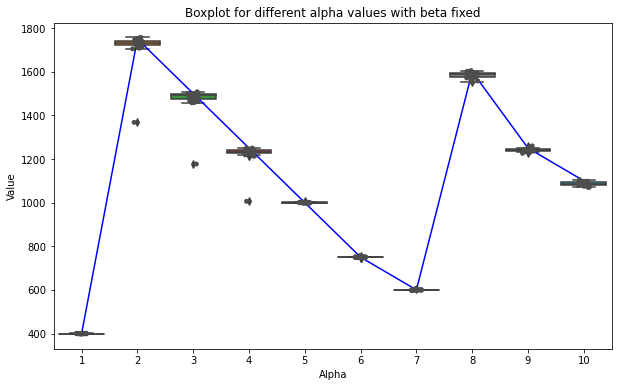

In [72]:
alpha_name_list = []
for i in range(1, 11):
    alpha_name_list.append(str(i))
    

final_alpha_df_beta_fixed = pd.DataFrame(final_alpha_list_beta_fixed, columns=alpha_name_list)


fig, ax = plt.subplots(figsize = (10,6))
sns.boxplot(data=final_alpha_df_beta_fixed)
sns.stripplot(data=final_alpha_df_beta_fixed, color = '.3', size = 5)

locs=ax.get_xticks()
ax.plot(locs, alpha_list_true, 'b-')

plt.xlabel('Alpha')
plt.ylabel('Value')
#plt.rc('xtick', labelsize = 15)
#plt.rc('ytick', labelsize = 15)
plt.title('Boxplot for different alpha values with beta fixed') 
fig.savefig("Boxplot for different alpha values with beta fixed")

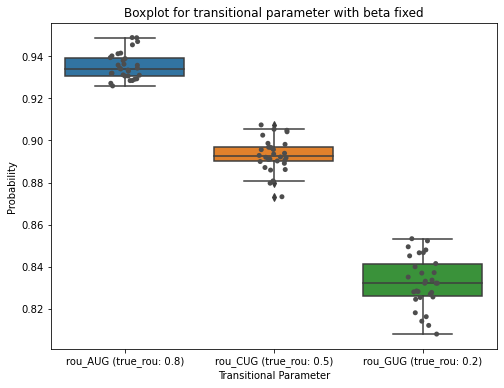

In [73]:
rou_beta_fixed_AUG = []
rou_beta_fixed_CUG = []
rou_beta_fixed_GUG = []
for element in final_trans_beta_fixed:
    rou_beta_fixed_AUG.append(element['AUG'])
    rou_beta_fixed_CUG.append(element['CUG'])
    rou_beta_fixed_GUG.append(element['GUG'])
    

final_trans_df_beta_fixed = pd.DataFrame({"rou_AUG (true_rou: 0.8)":rou_beta_fixed_AUG, "rou_CUG (true_rou: 0.5)": rou_beta_fixed_CUG, "rou_GUG (true_rou: 0.2)": rou_beta_fixed_GUG}, columns=['rou_AUG (true_rou: 0.8)', "rou_CUG (true_rou: 0.5)", "rou_GUG (true_rou: 0.2)"])

fig, ax = plt.subplots(figsize = (8, 6))
sns.boxplot(data=final_trans_df_beta_fixed)
sns.stripplot(data=final_trans_df_beta_fixed, color=".3", size=5)

#plt.axhline(y=0.7, color='r', linestyle='-')

plt.xlabel('Transitional Parameter')
plt.ylabel('Probability')
plt.title('Boxplot for transitional parameter with beta fixed') 
fig.savefig("Boxplot for transitional parameter with beta fixed")

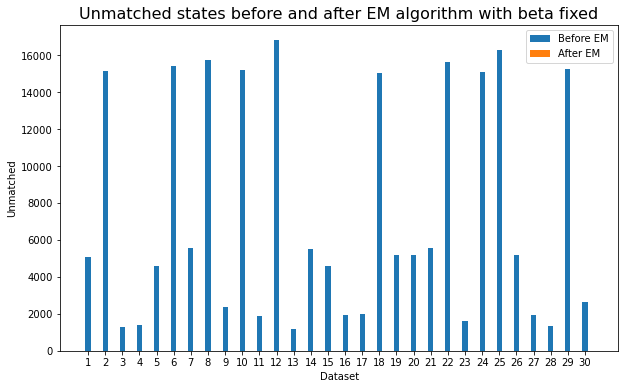

In [74]:
beta_list_beta_fixed = np.repeat([beta_list_true],30, axis = 1).reshape(30,10)

before_beta_fixed = differ_state(RNA_data, observed_data, start_alpha_list_beta_fixed, beta_list_beta_fixed, E, start_trans_beta_fixed, stop_codon_list, state_list_true)
after_beta_fixed = differ_state(RNA_data, observed_data, final_alpha_list_beta_fixed, beta_list_beta_fixed, E, final_trans_beta_fixed, stop_codon_list, state_list_true)

# plot
fig, ax = plt.subplots(figsize = (10,6))
plt.xticks(np.arange(1, 31, 1))
ind = np.arange(1, 31, 1)
width = 0.3

# label
plt.bar(ind, before_beta_fixed, width, label = 'Before EM')
plt.bar(ind + width, after_beta_fixed, width, label = 'After EM') 
plt.xlabel('Dataset')
plt.ylabel('Unmatched')
plt.title('Unmatched states before and after EM algorithm with beta fixed', fontsize = 16) 
plt.legend(loc = 'best')
fig.savefig("Unmatched states before and after EM algorithm with beta fixed")

In [75]:
actual_percentage_beta_fixed_AUG = percent(RNA_data, observed_data, start_alpha_list_beta_fixed, beta_list_beta_fixed, E, start_trans_beta_fixed, stop_codon_list, False, state_list_true, 'AUG')
previous_percentage_beta_fixed_AUG = percent(RNA_data, observed_data, start_alpha_list_beta_fixed, beta_list_beta_fixed, E, start_trans_beta_fixed, stop_codon_list, True, state_list_true, 'AUG')
estimated_percentage_beta_fixed_AUG = percent(RNA_data, observed_data, final_alpha_list_beta_fixed, beta_list_beta_fixed, E, final_trans_beta_fixed, stop_codon_list, True, state_list_true, 'AUG')

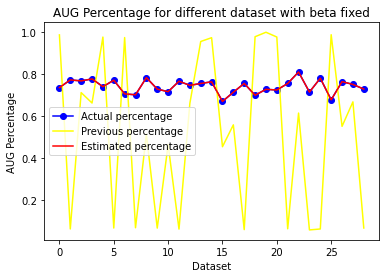

In [76]:
# Plot the graph with n features versus accuracy when it's 5-NN algorithms
fig, ax = plt.subplots(figsize = (6,4))
plt.plot(actual_percentage_beta_fixed_AUG, color = 'blue', marker = 'o', label = 'Actual percentage')
plt.plot(previous_percentage_beta_fixed_AUG, color = 'yellow', label = 'Previous percentage')
plt.plot(estimated_percentage_beta_fixed_AUG, color = 'red', label = 'Estimated percentage')
plt.legend()
plt.title('AUG Percentage for different dataset with beta fixed')
plt.xlabel('Dataset')
plt.ylabel('AUG Percentage')
plt.show()
fig.savefig('AUG Percentage for different dataset with beta fixed')

In [77]:
actual_percentage_beta_fixed_CUG = percent(RNA_data, observed_data, start_alpha_list_beta_fixed, beta_list_beta_fixed, E, start_trans_beta_fixed, stop_codon_list, False, state_list_true, 'CUG')
previous_percentage_beta_fixed_CUG = percent(RNA_data, observed_data, start_alpha_list_beta_fixed, beta_list_beta_fixed, E, start_trans_beta_fixed, stop_codon_list, True, state_list_true, 'CUG')
estimated_percentage_beta_fixed_CUG = percent(RNA_data, observed_data, final_alpha_list_beta_fixed, beta_list_beta_fixed, E, final_trans_beta_fixed, stop_codon_list, True, state_list_true, 'CUG')

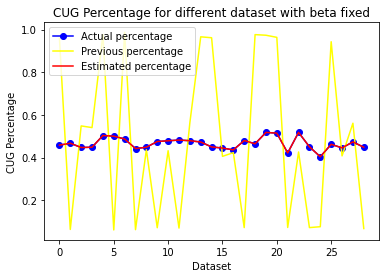

In [78]:
# Plot the graph with n features versus accuracy when it's 5-NN algorithms
fig, ax = plt.subplots(figsize = (6,4))
plt.plot(actual_percentage_beta_fixed_CUG, color = 'blue', marker = 'o', label = 'Actual percentage')
plt.plot(previous_percentage_beta_fixed_CUG, color = 'yellow', label = 'Previous percentage')
plt.plot(estimated_percentage_beta_fixed_CUG, color = 'red', label = 'Estimated percentage')
plt.legend()
plt.title('CUG Percentage for different dataset with beta fixed')
plt.xlabel('Dataset')
plt.ylabel('CUG Percentage')
plt.show()
fig.savefig('CUG Percentage for different dataset with beta fixed')

In [79]:
actual_percentage_beta_fixed_GUG = percent(RNA_data, observed_data, start_alpha_list_beta_fixed, beta_list_beta_fixed, E, start_trans_beta_fixed, stop_codon_list, False, state_list_true, 'GUG')
previous_percentage_beta_fixed_GUG = percent(RNA_data, observed_data, start_alpha_list_beta_fixed, beta_list_beta_fixed, E, start_trans_beta_fixed, stop_codon_list, True, state_list_true, 'GUG')
estimated_percentage_beta_fixed_GUG = percent(RNA_data, observed_data, final_alpha_list_beta_fixed, beta_list_beta_fixed, E, final_trans_beta_fixed, stop_codon_list, True, state_list_true, 'GUG')

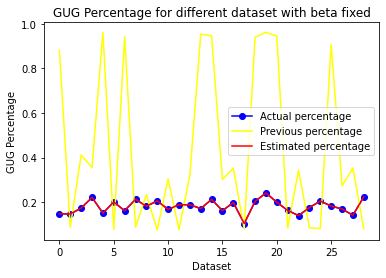

In [80]:
# Plot the graph with n features versus accuracy when it's 5-NN algorithms
fig, ax = plt.subplots(figsize = (6,4))
plt.plot(actual_percentage_beta_fixed_GUG, color = 'blue', marker = 'o', label = 'Actual percentage')
plt.plot(previous_percentage_beta_fixed_GUG, color = 'yellow', label = 'Previous percentage')
plt.plot(estimated_percentage_beta_fixed_GUG, color = 'red', label = 'Estimated percentage')
plt.legend()
plt.title('GUG Percentage for different dataset with beta fixed')
plt.xlabel('Dataset')
plt.ylabel('GUG Percentage')
plt.show()
fig.savefig('GUG Percentage for different dataset with beta fixed')